## ✈️ *TravelTide* - Customer Segmentation Project
---
### Data Preparation - User Level

### 1. Introduction

This notebook prepares the **user-level dataset** for exploratory analysis and customer segmentation.

The session-level data was cleaned and validated in **Notebook 03**, then aggregated into a user-level table where each row represents one user and summarizes stable patterns across:
- engagement and platform usage,
- booking and cancellation behavior,
- spending and trip characteristics,
- discount and price sensitivity.

The objectives of this notebook are to:
1. Verify structure, data types, and missingness at user level
2. Perform targeted exploratory analysis to understand user behavior distributions
3. Engineer higher-level features (including RFM-style signals and CLTV proxies),
4. Export a clean and interpretable dataset ready for segmentation and clustering in **Notebook 05**.


**Author**: Maria Petralia  
**Project**: TravelTide - Customer Segmentation & Perk Strategy  
**Context**: MasterSchool - Data Science Program  
**Date**: Feb 2026

### 2. Setup


###### Load Libraries

In [75]:
# Load Libraries
# ---------------------------------------------

# Data Handling & Analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
# Plotly Express
import plotly.express as px


# Display utilities
from IPython.display import display, HTML

###### Set Global Plotting Style

In [76]:
# Global Plotting Style
# ---------------------------------------------

# Base seaborn style
sns.set(style="ticks")

# TravelTide visual identity (global palette)
travel_palette = [
    "#176C8C",  # Blue 1 - mid ocean
    "#7E6A9F",  # Purple 1 - lavender
    "#6BBBD9",  # Blue 3 - light sky
    "#D0F3FF",  # Blue 4 - light blue
    "#E8C9A1",  # Sand 1 - warm sand
    "#F1D7B5",  # Sand 2 - soft beige
    "#F4B998",  # Sand 3 - peach sand
    "#DD1111",  # Red 1 - bright red
]

### 3. User-Level Dataset Overview

#### 3.1 Load User-Level Dataset

In [77]:
from google.colab import drive
import os

drive.mount('/content/drive')

os.chdir("/content/drive/MyDrive/Masterschool/TravelTide")
print(os.getcwd())

# Load the user-level CSV exported in Notebook 03
csv_path = "data/intermediate/user_level.csv"
ul_df = pd.read_csv(csv_path, low_memory=False)

print("User-level dataset loaded.")

# Quick preview
ul_df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Masterschool/TravelTide
User-level dataset loaded.


,user_id,gender,married,birthdate,has_children,home_country,home_city,home_airport,sign_up_date,first_session_date,...,avg_page_clicks,avg_distance_km,max_distance_km,avg_nights,max_nights,avg_seats,avg_rooms,avg_checked_bags,avg_trip_duration_days,max_trip_duration_days
0,23557,F,True,1958-12-08,False,usa,new york,LGA,2021-07-22,2023-01-04 19:30:00,...,10.250,NaN,NaN,10.0,18.0,NaN,1.5,NaN,NaN,NaN
1,94883,F,True,1972-03-16,False,usa,kansas city,MCI,2022-02-07,2023-01-10 12:20:00,...,9.125,1453.666128,1536.436758,1.0,1.0,1.5,1.5,0.5,2.5,3.0
2,101486,F,True,1972-12-07,True,usa,tacoma,TCM,2022-02-17,2023-01-21 08:02:00,...,16.375,965.340568,965.340568,4.5,5.0,1.0,1.5,0.0,5.0,5.0
3,101961,F,True,1980-09-14,False,usa,boston,BOS,2022-02-17,2023-01-19 03:38:00,...,15.750,1321.684183,4003.264513,4.4,8.0,1.0,1.0,0.4,5.8,9.0
4,106907,F,True,1978-11-17,True,usa,miami,TNT,2022-02-24,2023-01-10 17:24:00,...,30.000,13402.323077,13402.323077,11.0,11.0,6.0,3.0,5.0,14.0,14.0


**Note**:  
The dataset is already aggregated at user level.  
Each row represents a single user, and all features summarize behavior observed across multiple sessions and trips.


#### 3.2 Structural Overview

In [78]:
# Dataset shape
ul_df.shape

(5998, 34)

In [79]:
# Dataset info
ul_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5998 entries, 0 to 5997
Data columns (total 34 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   user_id                 5998 non-null   int64  
 1   gender                  5998 non-null   object 
 2   married                 5998 non-null   bool   
 3   birthdate               5998 non-null   object 
 4   has_children            5998 non-null   bool   
 5   home_country            5998 non-null   object 
 6   home_city               5998 non-null   object 
 7   home_airport            5998 non-null   object 
 8   sign_up_date            5998 non-null   object 
 9   first_session_date      5998 non-null   object 
 10  last_session_date       5998 non-null   object 
 11  last_booking_date       5532 non-null   object 
 12  tenure_days             5998 non-null   int64  
 13  n_sessions              5998 non-null   int64  
 14  n_booking_sessions      5998 non-null   

**Note**:  
The user-level dataset contains **5,998 users** and **32 features**.

All users have complete demographic, engagement, and booking summary information.
Missing values appear **only** in product-specific features:

- **Flight-related features** (`avg_distance_km`, `max_distance_km`, `avg_seats`, `avg_checked_bags`, `avg_trip_duration_days`, `max_trip_duration_days`) are missing for **835 users** who never booked a flight.

- **Hotel-related features** (`avg_nights`, `max_nights`, `avg_rooms`) are missing for **611 users** who never booked a hotel.

- `last_booking_date` is missing for users with no completed bookings.

This missingness is **behavior-driven and expected**, and does not indicate data quality issues.
No imputation is required at this stage.

All categorical and numerical features appear with the expected data types, with exceptions for some columns:
`birthdate`, `sign_up_date`, `first_session_date`, `last_session_date`, and `last_booking_date` are currently stored as object.

These fields will be converted to proper datetime types.



### 4. Data Validation and Typing

#### 4.1 Datetime Conversion

In [80]:
# Convert date columns to datetime
date_cols = [
    "birthdate",
    "sign_up_date",
    "first_session_date",
    "last_session_date",
    "last_booking_date"
]

for col in date_cols:
    ul_df[col] = pd.to_datetime(ul_df[col], errors="coerce")

# Check result
ul_df[date_cols].dtypes


,0
birthdate,datetime64[ns]
sign_up_date,datetime64[ns]
first_session_date,datetime64[ns]
last_session_date,datetime64[ns]
last_booking_date,datetime64[ns]


**Note**:  Date-related fields were originally stored as string objects and have been converted to
`datetime` format.  

This enables the computation of age, observed tenure, recency, and booking timing features used in the subsequent analysis and segmentation steps.

In [81]:
# Compute user age at last observed session
ul_df["age"] = (
    (ul_df["last_session_date"] - ul_df["birthdate"])
    .dt.days // 365
)

**Note**: Age is computed at the time of the user's last observed session, ensuring temporal consistency with the cohort window and avoiding forward-looking bias.    
This feature is introduced before exploratory analysis as a core demographic attribute.

#### 4.2 Sanity Checks

In [82]:
ul_df[["n_sessions", "n_booking_sessions"]].describe()

,n_sessions,n_booking_sessions
count,5998.000000,5998.000000
mean,8.167222,2.646382
std,0.503328,1.508963
min,5.000000,0.000000
25%,8.000000,2.000000
50%,8.000000,3.000000
75%,8.000000,4.000000
max,12.000000,8.000000


**Note**: `n_booking_sessions` counts **booking sessions only** (`cancellation = False`), where a trip was created (at least one product booked).   
This metric captures **booking intent and planning behavior**, regardless of whether the trip was later cancelled.
Cancellations are modeled separately as a **risk dimension** (`cancelled_trips`, `cancellation_rate`) and do not alter booking counts.

In [83]:
ul_df[["booking_rate", "cancellation_rate"]].describe()

,booking_rate,cancellation_rate
count,5998.000000,5998.000000
mean,0.324685,0.044899
std,0.185207,0.159972
min,0.000000,0.000000
25%,0.222222,0.000000
50%,0.333333,0.000000
75%,0.500000,0.000000
max,1.000000,1.000000


**Note**:
- `booking_rate` is defined as `n_booking_sessions` / `n_sessions` and measures how often a user's sessions culminate in a **booking event**.   
It reflects **conversion propensity at booking time**, not realized revenue.

Trips that are later cancelled are still counted as bookings; cancellation behavior is analyzed separately via `cancellation_rate`.

In [84]:
# Basic numeric distributions
ul_df.describe()

,user_id,birthdate,sign_up_date,first_session_date,last_session_date,last_booking_date,tenure_days,n_sessions,n_booking_sessions,n_trip_sessions,...,avg_distance_km,max_distance_km,avg_nights,max_nights,avg_seats,avg_rooms,avg_checked_bags,avg_trip_duration_days,max_trip_duration_days,age
count,5998.000000,5998,5998,5998,5998,5532,5998.000000,5998.000000,5998.000000,5998.000000,...,5163.000000,5163.000000,5387.000000,5387.000000,5163.000000,5387.000000,5163.000000,5163.000000,5163.000000,5998.000000
mean,545440.695565,1982-03-13 01:45:09.303100992,2023-01-20 02:26:12.524174592,2023-01-26 13:43:23.957985792,2023-06-17 05:29:17.908969472,2023-05-10 18:36:30.401301504,141.154051,8.167222,2.646382,2.747249,...,2357.695394,3163.372121,4.476690,6.592909,1.216935,1.198560,0.600262,5.293552,7.148363,40.782761
min,23557.000000,1935-05-10 00:00:00,2021-07-22 00:00:00,2022-05-06 22:16:00,2023-02-18 20:27:00,2022-05-16 14:25:00,23.000000,5.000000,0.000000,0.000000,...,27.440552,27.440552,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,16.000000
25%,517152.000000,1974-09-26 06:00:00,2023-01-08 00:00:00,2023-01-10 16:53:00,2023-06-01 18:25:15,2023-03-28 22:19:30,121.000000,8.000000,2.000000,2.000000,...,1478.536877,2080.167296,2.666667,4.000000,1.000000,1.000000,0.250000,3.750000,5.000000,34.000000
50%,540542.000000,1981-10-20 12:00:00,2023-01-19 00:00:00,2023-01-20 15:38:00,2023-06-25 03:48:00,2023-05-19 12:02:30,145.000000,8.000000,3.000000,3.000000,...,2032.712792,2897.015133,3.750000,5.000000,1.000000,1.000000,0.500000,4.666667,6.000000,41.000000
75%,574146.000000,1989-04-07 18:00:00,2023-02-05 00:00:00,2023-02-05 21:16:15,2023-07-09 18:15:45,2023-06-25 21:30:45,166.000000,8.000000,4.000000,4.000000,...,2748.275850,3814.927468,5.500000,9.000000,1.333333,1.333333,1.000000,6.000000,9.000000,48.000000
max,844489.000000,2006-12-28 00:00:00,2023-05-18 00:00:00,2023-05-18 16:22:00,2023-07-28 19:58:52,2023-07-20 22:03:00,430.000000,12.000000,8.000000,9.000000,...,15935.659875,17404.917859,30.000000,43.000000,6.000000,4.000000,5.666667,27.000000,36.000000,88.000000
std,64924.749760,NaN,NaN,NaN,NaN,NaN,32.425509,0.503328,1.508963,1.559387,...,1697.848379,2188.559225,2.846284,4.505767,0.447324,0.353712,0.512556,2.735723,3.931917,12.055621


**Note**: The numerical features show coherent and behaviorally meaningful patterns.

User engagement is controlled by cohort design but still exhibits variability in session intensity, interaction depth, and return frequency.
Booking activity is sparse relative to total sessions, while cancellations remain rare.

Monetary and travel-related features are highly right-skewed, with a small group of users generating a disproportionate share of spend and long-distance trips.
Overall, the distributions suggest clear heterogeneity in engagement, conversion behavior, and value generation, supporting the presence of distinct user profiles explored in the following EDA.

In [85]:
# Basic categorical distributions
ul_df.describe(include=["object", "category", "bool"])

,gender,married,has_children,home_country,home_city,home_airport
count,5998,5998,5998,5998,5998,5998
unique,3,2,2,2,105,159
top,F,False,False,usa,new york,LGA
freq,5292,3356,4040,4991,680,362


**Note**: Categorical features show a mix of highly concentrated and high-cardinality attributes.

Gender, marital status, parental status, and home country are strongly skewed, reflecting a dominant core user profile, while home city and home airport display substantial diversity.   
This combination suggests that demographic variables may act as coarse descriptors, whereas geographic attributes capture richer behavioral context and may differentiate users with similar engagement and booking patterns.

### 5 Exploratory Data Analysis

From user characteristics to trip anatomy, commitment behavior, and value synthesis

In [86]:
# make a copy of the original dataset for analysis
ul_df_analysis = ul_df.copy()

#### 5.1 Who are these users?

##### 5.1.1 Age Distribution

###### Age Distribution of Users - Histogram

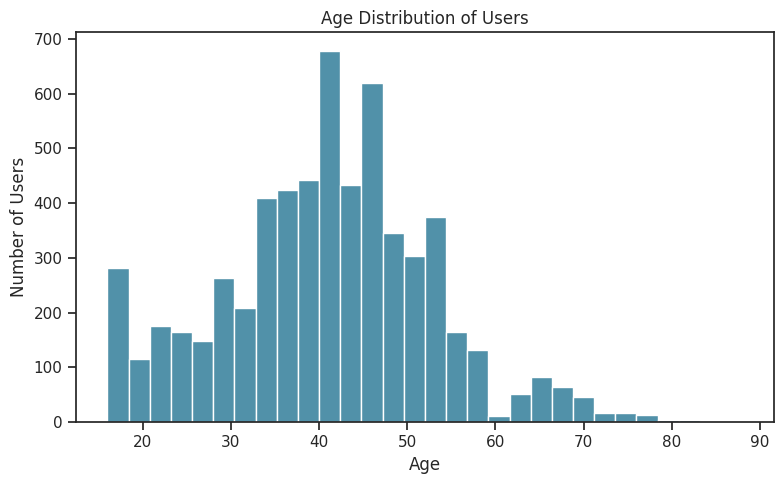

In [87]:
# Distribution of user age to understand the demographic profile of the cohort
plt.figure(figsize=(8,5))
sns.histplot(ul_df_analysis["age"], bins=30, color=travel_palette[0])
plt.title("Age Distribution of Users")
plt.xlabel("Age")
plt.ylabel("Number of Users")
plt.tight_layout()
plt.show()

**Note**: The age distribution is concentrated around the adult working-age population, with a clear peak between approximately 35 and 50 years.  
Younger users (below 25) and older users (above 65) are present but represent a smaller share of the cohort.  

Overall, the distribution appears smooth and realistic, suggesting no major anomalies in age computation and a user base largely composed of travelers in economically active life stages.

##### 5.1.2 User Observed Tenure

###### User Observed Tenure Distribution (days) - Histogram

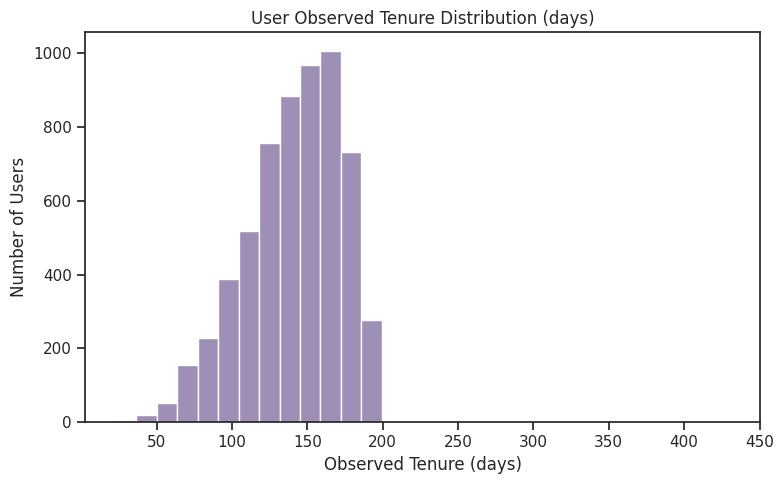

In [88]:
# Analyze user observed tenure to assess how long users have been active on the platform
plt.figure(figsize=(8,5))
sns.histplot(ul_df_analysis["tenure_days"], bins=30, color=travel_palette[1])
plt.title("User Observed Tenure Distribution (days)")
plt.xlabel("Observed Tenure (days)")
plt.ylabel("Number of Users")
plt.tight_layout()
plt.show()

**Note**: Tenure refers to the observed activity window (from first to last recorded session), not time since sign-up.

Observed user tenure is strongly concentrated between 100 and 200 days, with a peak around 140-160 days.  
This reflects the cohort definition applied upstream, which focuses on users active after early 2023 and ensures a comparable observation window across users.

Very short-tenure users are rare, indicating that users with only minimal post-cutoff activity are largely excluded.
At the same time, extremely long-tenure users are limited, reducing potential bias from legacy behavior.

Overall, this distribution confirms that the user-level dataset represents a recent, mature, and behaviorally comparable cohort, suitable for exploratory analysis and segmentation.

##### 5.1.3 Age vs Platform Tenure

###### User Age vs Platform Tenure - Scatter Plot

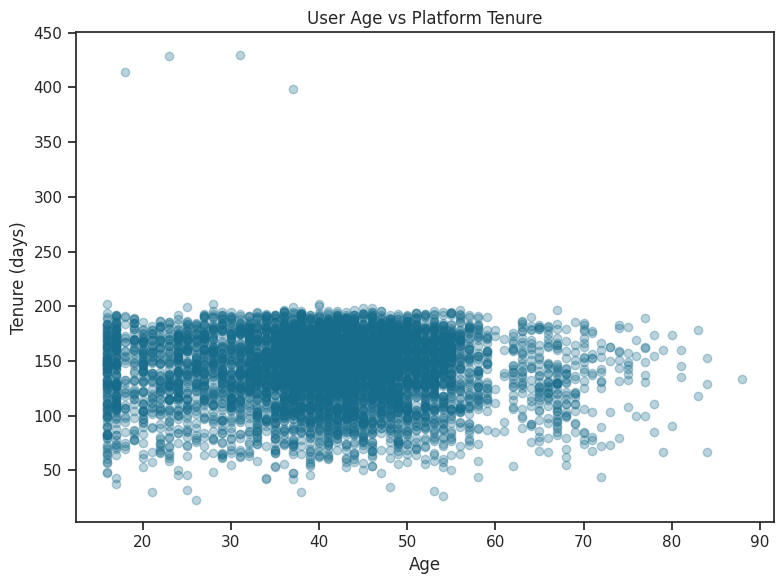

In [89]:
# Relationship between age and user tenure
plt.figure(figsize=(8,6))

plt.scatter(
    ul_df_analysis["age"],
    ul_df_analysis["tenure_days"],
    alpha=0.3,
    color=travel_palette[0]
)

plt.title("User Age vs Platform Tenure")
plt.xlabel("Age")
plt.ylabel("Tenure (days)")
plt.tight_layout()
plt.show()

**Note**: The scatter plot shows no clear dependency between user age and platform tenure.
Most users, regardless of age, exhibit tenure between 100 and 200 days.

This pattern reflects the observed activity window defined by the cohort selection, rather than differences in time since sign-up.

A higher density is observed in the 35-50 age range, reflecting the dominant demographic segment rather than an age-driven engagement effect.

#### 5.2 Engagement and Platform Usage

##### 5.2.1 Engagement Intensity

###### Number of Sessions per User - Histogram

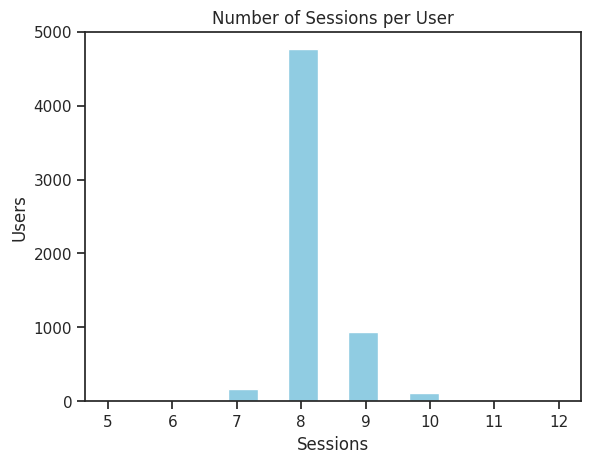

In [90]:
# Distribution of total number of sessions per user
# to assess engagement intensity within the cohort
sns.histplot(ul_df_analysis["n_sessions"], bins=15, color=travel_palette[2])
plt.title("Number of Sessions per User")
plt.xlabel("Sessions")
plt.ylabel("Users")
plt.show()

**Note**: The number of sessions per user falls within a narrow range, based on the cohort criteria used earlier.

This helps ensure that differences in booking behavior and value come from how users actually behave, not from outliers with unusually high activity.

##### 5.2.2 Engagement Depth

###### Session Duration vs Interaction Depth - Scatter Plot

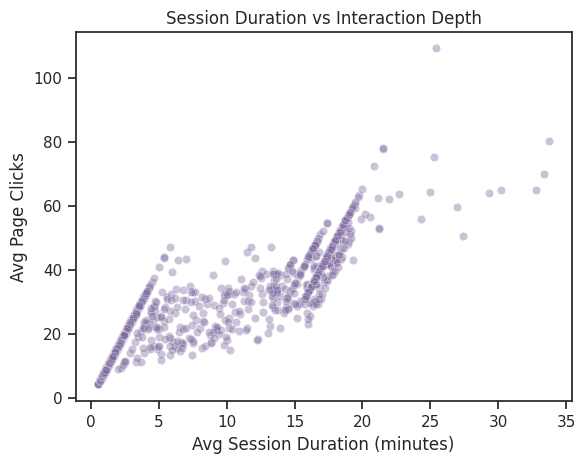

In [91]:
# Relationship between session duration and interaction depth
# to validate engagement-related features
sns.scatterplot(
    data=ul_df_analysis,
    x="avg_session_duration",
    y="avg_page_clicks",
    alpha=0.4,
    color=travel_palette[1]
)
plt.title("Session Duration vs Interaction Depth")
plt.xlabel("Avg Session Duration (minutes)")
plt.ylabel("Avg Page Clicks")
plt.show()

**Note**: At session level (Notebook 03), booking behavior was associated with longer sessions and a slower accumulation of page clicks, reflecting deliberate decision-making rather than rapid exploration.  

At user level, these session dynamics aggregate into stable engagement profiles: users with higher average session duration also show higher average interaction depth.

Booking propensity is linked to sustained, deliberate engagement patterns rather than short, click-intensive browsing.

#### 5.3 Booking Behavior and Monetary Signals

##### 5.3.1 Booking Propensity

###### Booking Rate per User - Histogram

Throughout this notebook, booking-based metrics describe **intent at booking time**.  
Post-booking outcomes (cancellations) are treated as a separate behavioral dimension and are not used to “net out” bookings.

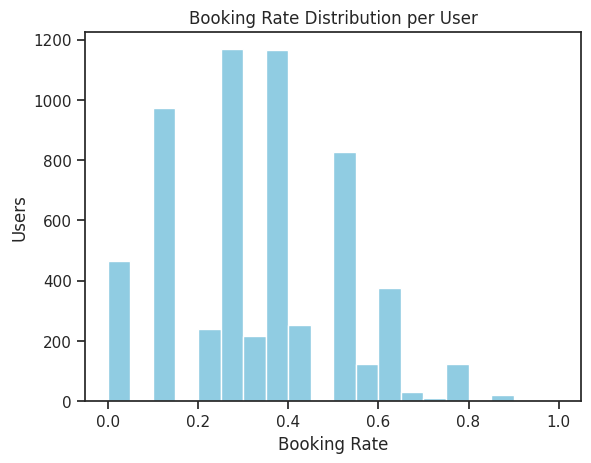

In [92]:
# Distribution of booking rate across users
# to assess heterogeneity in conversion behavior
sns.histplot(ul_df_analysis["booking_rate"], bins=20, color=travel_palette[2])
plt.title("Booking Rate Distribution per User")
plt.xlabel("Booking Rate")
plt.ylabel("Users")
plt.show()

**Note**: Booking rates differ a lot across users, even among those with similar overall activity.

Some users book in about one-third of their sessions, while others book much more often or almost never. This shows that the variation comes from different decision-making styles, not from differences in how much they use the platform.

##### 5.3.2 Value vs Booking Frequency

###### Booked Trip Sessions vs Total Spend - Scatter Plot

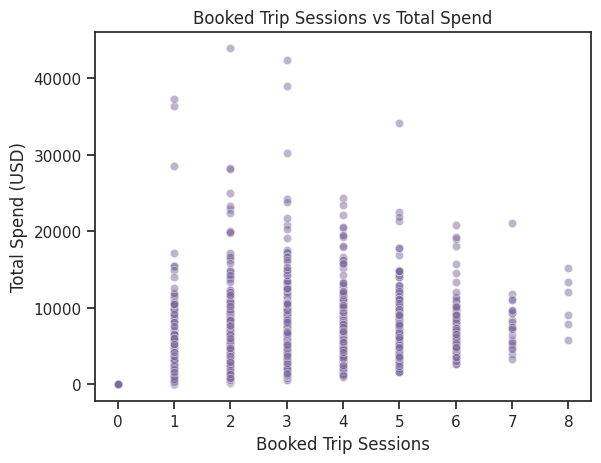

In [93]:
# Relationship between number of booked trips and total monetary value
# to explore user value profiles
sns.scatterplot(
    data=ul_df_analysis,
    x="n_booking_sessions",
    y="total_spend",
    alpha=0.5,
    color=travel_palette[1]
)
plt.title("Booked Trip Sessions vs Total Spend")
plt.xlabel("Booked Trip Sessions")
plt.ylabel("Total Spend (USD)")
plt.show()

**Note**: Total spend increases with the number of booked trips, but the relationship is far from linear.

Users with the same booking frequency can generate very different levels of monetary value, suggesting that *what* users book matters as much as *how often* they book.

**Note**: **Spend distribution** exhibits strong right skewness, with a small number of extreme values.  
These observations are retained, as they correspond to legitimate long-haul or high-commitment trips and **represent meaningful behavioral patterns** rather than noise.

##### 5.3.3 User Value vs Booking Intensity

###### User Value vs Booking Intensity - Multivariate Scatter

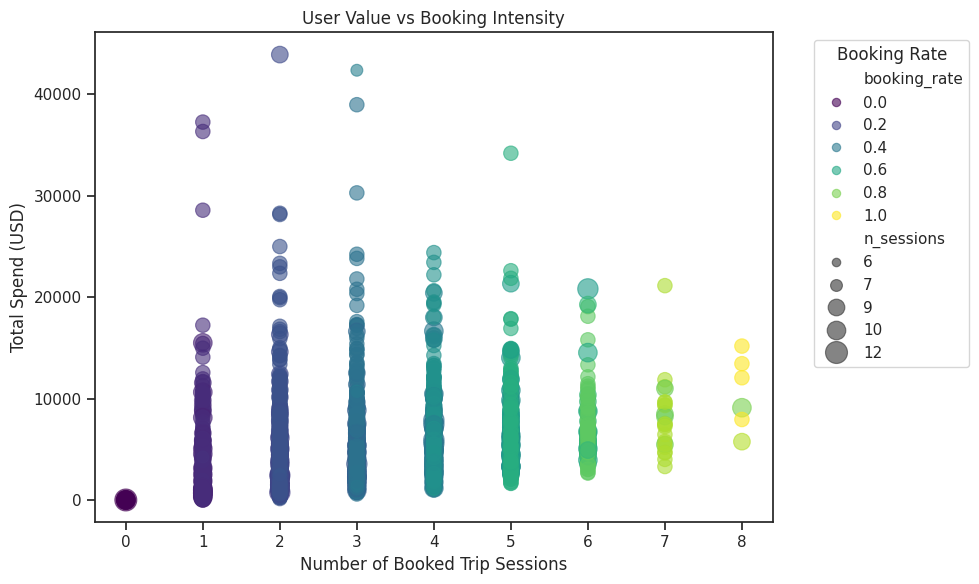

In [94]:
# User Value vs Booking Intensity
plt.figure(figsize=(10, 6))

scatter = sns.scatterplot(
    data=ul_df_analysis,
    x="n_booking_sessions",
    y="total_spend",
    size="n_sessions",
    hue="booking_rate",
    palette="viridis",
    alpha=0.6,
    sizes=(2, 250),
    edgecolor=None
)

plt.title("User Value vs Booking Intensity")
plt.xlabel("Number of Booked Trip Sessions")
plt.ylabel("Total Spend (USD)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", title="Booking Rate")
plt.tight_layout()
plt.show()


**Note**: This scatter plot examines how booking behavior relates to the total monetary value generated by users.
While booking rate and booking intensity tend to move together due to the cohort structure, total spend varies widely even among users with the same number of booked trips.

This dispersion indicates that **user value is not driven by booking frequency alone**.
Instead, the highest-value users cluster around moderate booking activity (1-5 booked sessions) combined with higher booking efficiency.
Users with many booking sessions tend to generate lower value, despite their higher activity levels.

These patterns suggest that value is shaped primarily by trip-level characteristics rather than by how often users book, motivating a deeper exploration of what happens within each trip (distance, duration, group size, and spend composition).

Booking behavior alone cannot explain user value.  
To understand what differentiates high-value users, the analysis now shifts inside the trip itself.

#### 5.4 Inside the Trip

##### 5.4.1 Trip Anatomy: Travel Context

###### Average Nights per Trip - Box Plot

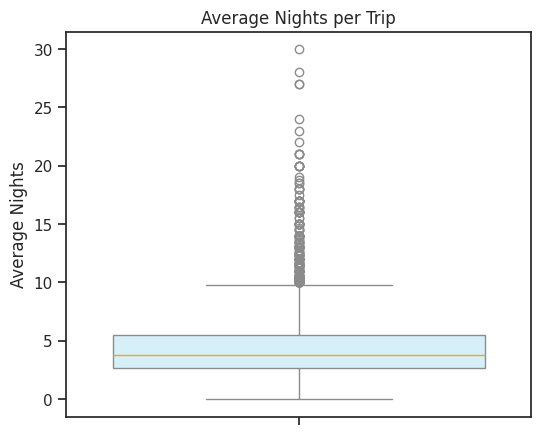

In [95]:
# Average nights per trip box plot
plt.figure(figsize=(6,5))
sns.boxplot(
    data=ul_df_analysis,
    y="avg_nights",
    color = travel_palette[3],
    # set the median's color to orange to enfatize it
    medianprops=dict(color="orange", linewidth=1)
)
plt.title("Average Nights per Trip")
plt.ylabel("Average Nights")
plt.show()

**Note**: The distribution of average nights per trip is strongly concentrated around short stays, with a median of roughly 3-4 nights.  
This indicates that most users engage in relatively standard trips, such as short leisure breaks or brief business travel.

However, the long right tail reveals a smaller group of users planning extended stays, sometimes exceeding several weeks.
These longer trips likely involve higher planning effort, higher total spend, and higher commitment, making them behaviorally distinct from the majority of the user base.

This highlights that trip duration is a key dimension of trip complexity, not simply a reflection of booking frequency.

###### Average Checked Bags - Histogram

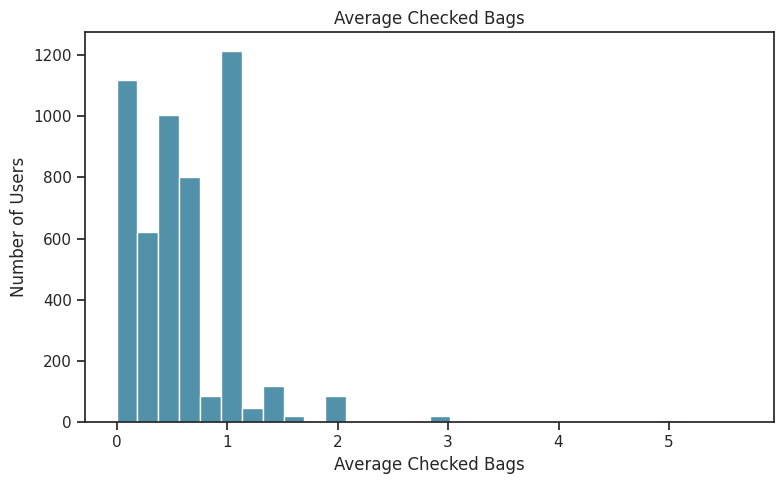

In [96]:
# Average ckecked bags - Histogram
plt.figure(figsize=(8,5))
sns.histplot(ul_df_analysis["avg_checked_bags"], bins=30, color=travel_palette[0])
plt.title("Average Checked Bags")
plt.xlabel("Average Checked Bags")
plt.ylabel("Number of Users")
plt.tight_layout()
plt.show()

###### Average Checked Bags - Bar Plot

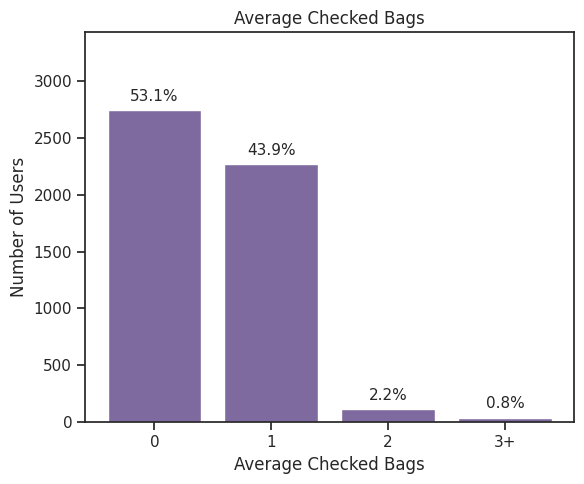

In [97]:
# Average checked bags bar plot with percentages
plt.figure(figsize=(6,5))

# Binning 0, 1, 2, 3+
bins = pd.cut(
    ul_df_analysis["avg_checked_bags"],
    bins=[-0.1, 0.5, 1.5, 2.5, ul_df_analysis["avg_checked_bags"].max()],
    labels=["0", "1", "2", "3+"]
)

counts = bins.value_counts().reindex(["0", "1", "2", "3+"], fill_value=0)

# Plot
plt.bar(counts.index, counts.values, color=travel_palette[1])

# percentages
total = counts.sum()
percentages = (counts / total * 100).round(1)

# add percentages
for i, p in enumerate(percentages.values):
    label = f"{p}%"
    v = counts.values[i]
    plt.text(i, v + max(counts.values)*0.02,
        label, ha='center', va='bottom', fontsize=11)

# more space between labels and borders
plt.ylim(0, max(counts.values) * 1.25)
plt.title("Average Checked Bags")
plt.xlabel("Average Checked Bags")
plt.ylabel("Number of Users")

plt.tight_layout()
plt.show()


**Note**: Most users travel with zero or one checked bag on average, suggesting light and efficient travel behavior for the majority of trips.

At the same time, a non-negligible subset of users consistently travels with multiple checked bags, indicating more complex travel contexts such as families, group travel, or longer stays.

The skewed distribution shows that baggage usage is not evenly distributed across users, and likely reflects structural differences in trip type rather than random variation.

Average baggage volume therefore emerges as a strong indicator of travel complexity and logistical needs, complementing metrics like nights and seats.

###### Seats vs Rooms - Scatter Plot

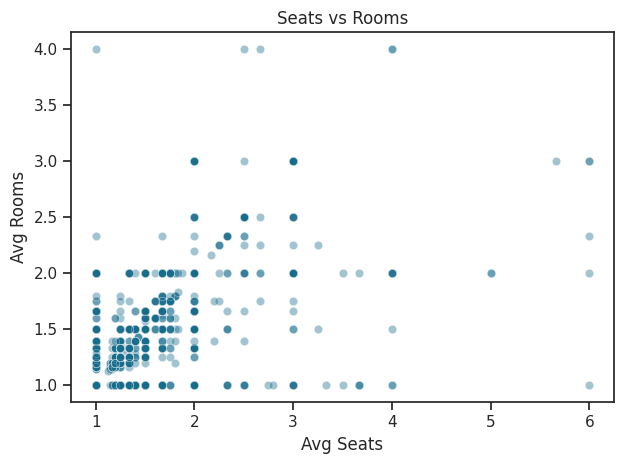

In [98]:
# Seats vs rooms scatter plot
# trip structure
sns.scatterplot(
    data=ul_df_analysis,
    x="avg_seats",
    y="avg_rooms",
    alpha=0.4,
    color=travel_palette[0]
)
plt.title("Seats vs Rooms")
plt.xlabel("Avg Seats")
plt.ylabel("Avg Rooms")
plt.tight_layout()
plt.show()

**Note**: The scatter plot shows a clear positive relationship between the average number of seats booked and the average number of hotel rooms.

Most users cluster around **1-2 seats and 1 room**, reflecting solo travelers or couples booking standard trips.
As the number of seats increases, the number of rooms also tends to increase, indicating coordinated travel planning rather than independent bookings.

This pattern confirms that flight and accommodation decisions are often made jointly, and that higher seat counts correspond to group or family travel, where logistical complexity naturally increases.

Importantly, this coherence suggests that **seats and rooms are not redundant features**, but **complementary signals describing trip structure and group composition**.

###### Travel Style: Distance vs Nights - Scatter Plot

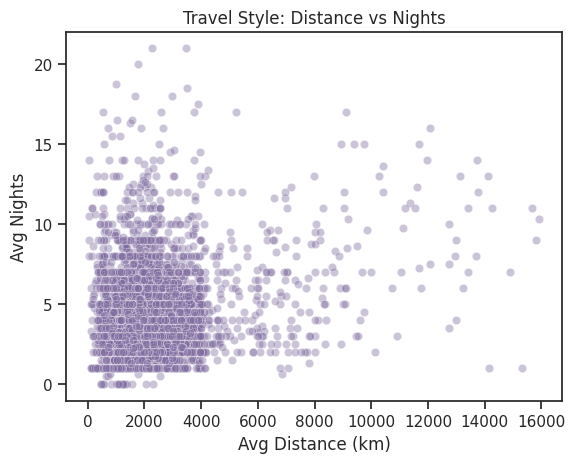

In [99]:
# Explore travel styles by comparing distance and length of stay
sns.scatterplot(
    data=ul_df_analysis,
    x="avg_distance_km",
    y="avg_nights",
    alpha=0.4,
    color=travel_palette[1]
)
plt.title("Travel Style: Distance vs Nights")
plt.xlabel("Avg Distance (km)")
plt.ylabel("Avg Nights")
plt.show()

**Note**: Most users cluster around short to mid range trips with relatively limited stays, indicating a prevalence of standard leisure or short business travel.

Long-haul trips and extended stays appear as a smaller, distinct subset, likely associated with higher spend and different planning dynamics explored later in the analysis.

###### Booking Behavior vs Average Checked Bags - Scatter Plot

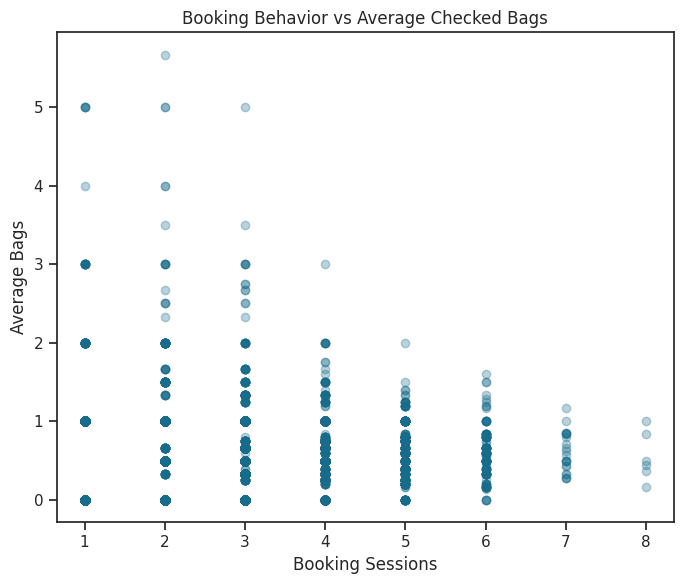

In [100]:
# Baggage usage and booking beahvior scatter plot
plt.figure(figsize=(7,6))

plt.scatter(
    x = ul_df_analysis["n_booking_sessions"],
    y = ul_df_analysis["avg_checked_bags"],
    alpha=0.3,
    color=travel_palette[0]
)

plt.title("Booking Behavior vs Average Checked Bags")
plt.xlabel("Booking Sessions")
plt.ylabel("Average Bags")
plt.tight_layout()
plt.show()

**Note**: Users with higher booking frequency tend to travel with a lower and more stable number of checked bags, while users with fewer booking sessions show much higher variability in baggage usage.

This suggests that frequent bookers converge toward more standardized and predictable travel patterns, whereas low-frequency users include a mix of light travelers and logistics-heavy trips.

Average baggage volume therefore appears to reflect trip context and planning complexity rather than engagement intensity alone.

##### 5.4.2 Trip Value, Risk, Commitment

###### Feature Engineering - nights_bucket

In [101]:
# Nights Buckets
ul_df_analysis["nights_bucket"] = pd.cut(
    ul_df_analysis["avg_nights"],
    bins=[-0.1, 2, 5, 10, ul_df_analysis["avg_nights"].max()],
    labels=[
        "Short stay (≤2 nights)",
        "Standard stay (3-5 nights)",
        "Long stay (6-10 nights)",
        "Extended stay (>10 nights)"
    ]
)


**Note**: Trip duration is discretized into four interpretable buckets based on average nights per trip:

- **Short stay (≤2 nights)**: very short leisure trips or brief business travel  
- **Standard stay (3-5 nights)**: the most common travel pattern, including weekend and short holiday trips  
- **Long stay (6-10 nights)**: extended leisure travel or longer business assignments  
- **Extended stay (>10 nights)**: high-commitment trips such as long vacations, relocations, or complex itineraries  

These thresholds are intentionally **behavioral rather than statistical**.  
They reflect meaningful differences in planning effort, commitment, and logistical complexity, rather than being optimized for numerical separation.

By using average nights per trip, the buckets capture **typical user behavior** rather than single extreme trips.

###### Cancellation Rate by Trip Night Duration - Box Plot

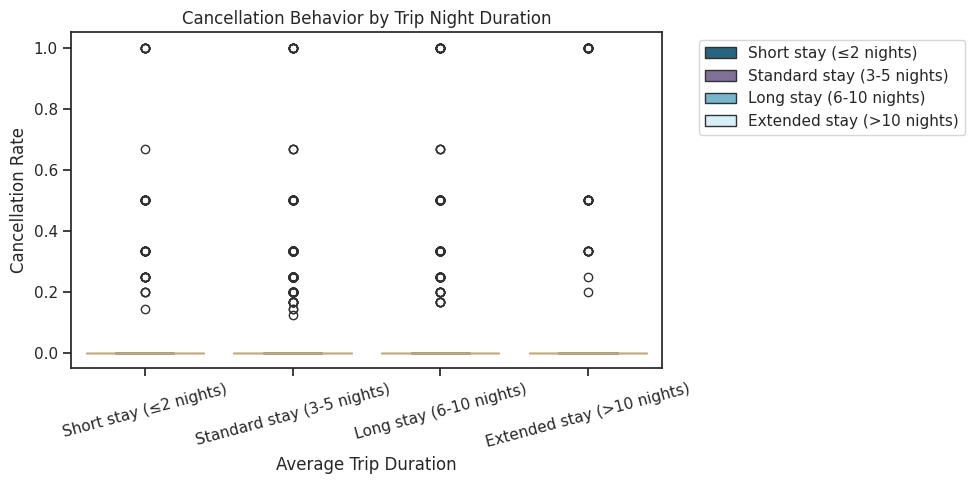

In [102]:
# Cancellation rate by trip night duration box plot
plt.figure(figsize=(10,5))

sns.boxplot(
    data=ul_df_analysis,
    x="nights_bucket",
    y="cancellation_rate",
    hue=ul_df_analysis["nights_bucket"],
    palette=travel_palette[0:4],
    medianprops=dict(color="orange", linewidth=1)
)

plt.title("Cancellation Behavior by Trip Night Duration")
plt.xlabel("Average Trip Duration")
plt.ylabel("Cancellation Rate")
plt.xticks(rotation=15)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

**Note**: This box plot shows the distribution of user-level cancellation rates across trip duration buckets.

Across all trip types, the median cancellation rate remains close to zero, indicating that most users, regardless of trip length, do not frequently cancel bookings.

However, longer and extended stays exhibit **wider dispersion and more extreme outliers**, indicating higher variability in cancellation behavior.

At this stage, the plot highlights **volatility rather than prevalence**:
it shows that high cancellation rates exist across all trip durations, but does not indicate how common they are within each group.

To assess whether longer trips are associated with a higher _concentration_ of cancellations, a distribution-based analysis is required and is examined next.

###### Feature Engineering - cancellation_rate_bucket

In [103]:
# Cancellation rate buckets: 5 buckets
def cancellation_bucket(rate):
    if rate == 0:
        return "0%"
    elif rate <= 0.20:
        return "1-20%"
    elif rate <= 0.40:
        return "21-40%"
    elif rate < 1:
        return "41-99%"
    else:
        return "100%"

ul_df_analysis["cancellation_bucket"] = (
    ul_df_analysis["cancellation_rate"]
    .apply(cancellation_bucket)
)
# # Define an explicit order for cancellation buckets to reflect increasing cancellation severity
cancellation_order = [
    "0%",
    "1-20%",
    "21-40%",
    "41-99%",
    "100%"
]
ul_df_analysis["cancellation_bucket"] = pd.Categorical(
    ul_df_analysis["cancellation_bucket"],
    categories=cancellation_order,
    ordered=True
)



In [104]:
# Distribution of cancellation rate by trip duration buckets
cancellation_night_table = (
    ul_df_analysis
    .groupby(
        ["nights_bucket", "cancellation_bucket"],
        observed=True
    )
    .size()
    .reset_index(name="users")
)

# Calculate percentage of users in each bucket
cancellation_night_table["pct_users"] = (
    cancellation_night_table
    .groupby("nights_bucket", observed=True)["users"]
    .transform(lambda x: x / x.sum())
)

# Pivot for readability
cancellation_night_pivot = (
    cancellation_night_table
    .pivot(
        index="nights_bucket",
        columns="cancellation_bucket",
        values="pct_users"
    )
    .fillna(0)
    .round(3)
)

display(cancellation_night_pivot)


cancellation_bucket,0%,1-20%,21-40%,41-99%,100%
nights_bucket,,,,,
Short stay (≤2 nights),0.924,0.005,0.035,0.028,0.008
Standard stay (3-5 nights),0.911,0.018,0.053,0.015,0.003
Long stay (6-10 nights),0.878,0.010,0.061,0.039,0.012
Extended stay (>10 nights),0.784,0.004,0.037,0.071,0.104


**Note**: This table shows the **distribution of cancellation rates** across trip duration (nights) buckets.

Short and standard stays are dominated by users with no cancellations, accounting for more than 90% of users.
As trip duration increases, this share steadily declines.

Long and extended stays display a higher concentration of users with partial or full cancellations:

- **Extended stays** show a sharp increase in **100% cancellation rates**, exceeding 10%.
- The combined share of users with cancellation rates above 20% is substantially higher for long and extended trips than for shorter stays.

**Longer trips are not only more variable, but also structurally more fragile**.
Higher commitment and planning complexity translate into a greater likelihood of cancellation, reinforcing trip duration as a meaningful risk dimension.

###### Feature Engeneering - avg_spend_per_trip

In [105]:
# Average spend per booked trip
ul_df_analysis["avg_spend_per_trip"] = (
    ul_df_analysis["total_spend"] / ul_df_analysis["n_booking_sessions"]
).replace([np.inf, -np.inf], np.nan)

**Note**: `avg_spend_per_trip` reflects intended spend at booking time; cancellations are handled separately as a risk dimension.

###### Average Spend per Trip vs Number of Booked Trips - Scatter Plot

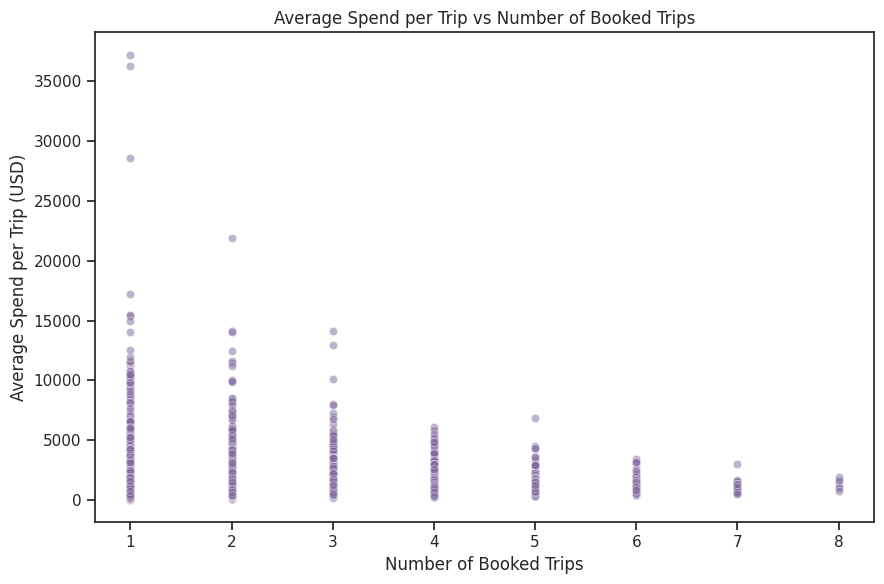

In [106]:
# Booked trips vs spend per trip
plt.figure(figsize=(9,6))
sns.scatterplot(
    data=ul_df_analysis,
    x="n_booking_sessions",
    y="avg_spend_per_trip",
    alpha=0.5,
    color = travel_palette[1]
)

plt.title("Average Spend per Trip vs Number of Booked Trips")
plt.xlabel("Number of Booked Trips")
plt.ylabel("Average Spend per Trip (USD)")
plt.tight_layout()
plt.show()


**Note**: Booked trips refer to booking sessions and may include trips that were later cancelled.

At this stage, spend per trip reflects **intended value at booking time**,
not realized revenue.

Users with a small number of booked trips show the highest variability in average spend per trip,
including the most expensive outliers.

As the number of booked trips increases, average spend per trip decreases and becomes more stable.
This suggests a transition from **occasional, high-commitment travel to more frequent and standardized booking behavior**.

Frequent bookers appear to optimize spend over time, indicating growing familiarity with the platform
and a shift toward more predictable travel patterns.

###### Feature Engineering - has_cancellation

In [107]:
# has_cancellation flag to assess the impact of cancellations
ul_df_analysis["has_cancellation"] = ul_df_analysis["cancellation_rate"] > 0

###### Average Spend per Trip vs Booking Frequency (Cancellation Highlighted)

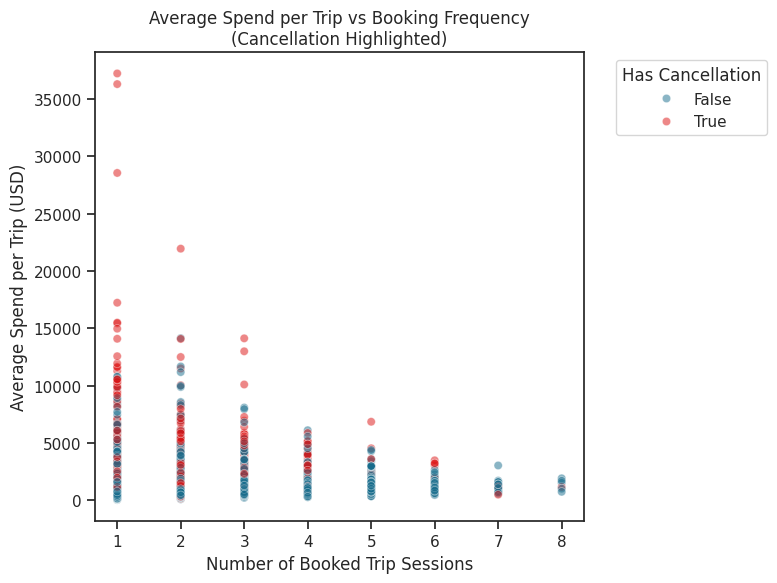

In [108]:
plt.figure(figsize=(8,6))

sns.scatterplot(
    data=ul_df_analysis,
    x="n_booking_sessions",
    y="avg_spend_per_trip",
    hue="has_cancellation",
    palette={False: travel_palette[0], True: travel_palette[7]},
    alpha=0.5
)

plt.title("Average Spend per Trip vs Booking Frequency\n(Cancellation Highlighted)")
plt.xlabel("Number of Booked Trip Sessions")
plt.ylabel("Average Spend per Trip (USD)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", title="Has Cancellation")
plt.tight_layout()
plt.show()


**Note**: This plot reveals a clear trade-off between **booking frequency** and **average spend per trip**.

Users with few booked trips exhibit a wide dispersion in spend, including the **highest per-trip values** in the dataset.
In contrast, users with **many booked trips** tend to converge toward **lower and more stable average spend**, suggesting more routine and budget-aware travel behavior.

Importantly, **cancellations are disproportionately concentrated among low-frequency, high-spend users**.
This indicates that high-value, infrequent bookings are more fragile and more likely to be abandoned, while frequent bookers display both higher commitment and lower cancellation risk.

To better understand whether these patterns represent distinct behavioral archetypes rather than a continuum, users are grouped into booking-cancellation profiles.

##### 5.4.3 Booking-Cancellation Behavioral Profiles

###### Distribution of Cancellations - Histogram

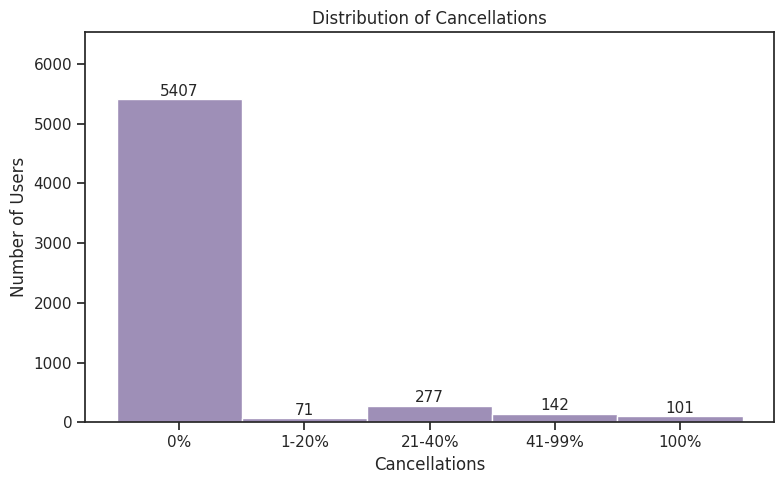

In [109]:
# Distribution of Cancellations - Histogram
# Create the plot
plt.figure(figsize=(8, 5))
ax = sns.histplot(
    ul_df_analysis["cancellation_bucket"],
    bins=len(cancellation_order),
    color=travel_palette[1]
)

# Title and labels
plt.title("Distribution of Cancellations")
plt.xlabel("Cancellations")
plt.ylabel("Number of Users")

# Add count labels above each bar
for patch in ax.patches:
    height = patch.get_height()
    x = patch.get_x() + patch.get_width() / 2
    ax.text(x, height + 5, f'{int(height)}', ha='center', va='bottom', fontsize=11)

# Add vertical padding to avoid clipping
ax.set_ylim(top=ax.get_ylim()[1] * 1.15)

plt.tight_layout()
plt.show()


**Note**: The distribution of cancellation behavior shows that most users never cancel any of their trips, while smaller groups exhibit occasional or frequent cancellations.   
This variability highlights different levels of planning stability and reliability across the user base.   

These behavioral differences will be combined with booking activity in the next section to form the booking-cancellation behavioral profiles.

**Note** To make booking and cancellation behavior interpretable at user level, continuous rates are discretized into coarse buckets.

**Booking intensity** is defined as:

- Low booking: booking_rate < 0.20
- Medium booking: 0.20 ≤ booking_rate < 0.50
- High booking: booking_rate ≥ 0.50

Cancellation behavior is defined as:

- No cancellations: cancellation_rate ≤ 0.01 (effectively zero)
- Occasional cancellations: 0.01 < cancellation_rate ≤ 0.30
- Frequent cancellations: cancellation_rate > 0.30

These thresholds are intentionally simple and asymmetric: booking rate is used to separate conversion propensity (low/medium/high), while cancellation rate is treated as a risk flag (most users are near zero, so the buckets focus on identifying the minority with repeated cancellations).
The goal is interpretability and actionable profiling rather than maximizing statistical separation.

######  Feature Engineering - booking_level, cancellation_level, booking_profile

In [110]:
# Create booking and cancellation rates into behavioral buckets
# Helper columns
ul_df_analysis["booking_level"] = pd.cut(
    ul_df_analysis["booking_rate"],
    bins=[-0.01, 0.2, 0.5, 1.0],
    labels=["Low booking", "Medium booking", "High booking"]
)

ul_df_analysis["cancellation_level"] = pd.cut(
    ul_df_analysis["cancellation_rate"],
    bins=[-0.01, 0.01, 0.3, 1.0],
    labels=["No cancellations", "Occasional cancellations", "Frequent cancellations"]
)

ul_df_analysis["booking_profile"] = (
    ul_df_analysis["booking_level"].astype(str)
    + " / "
    + ul_df_analysis["cancellation_level"].astype(str)
)

###### User Booking Behavior Profiles - Quadrant Scatter

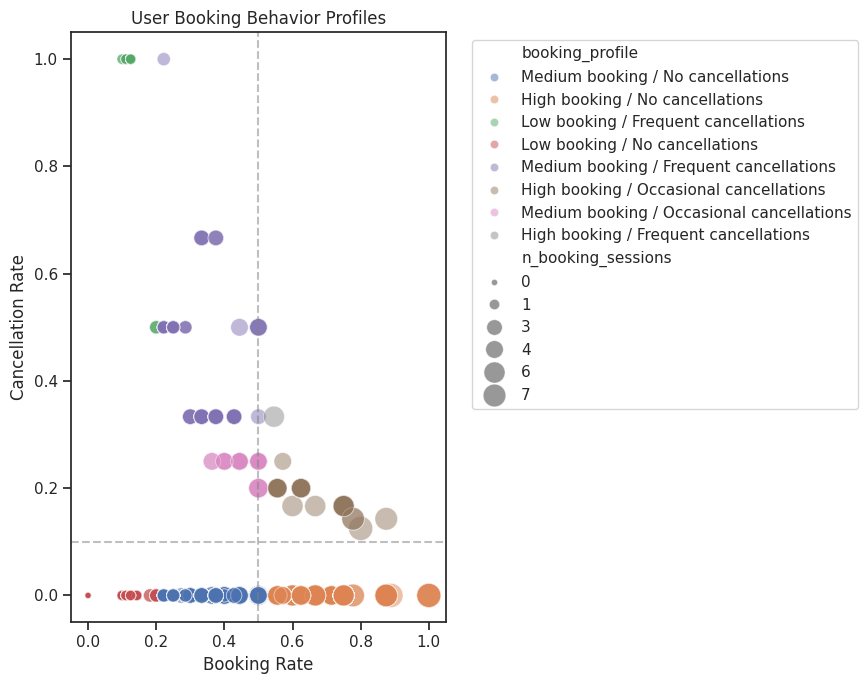

In [111]:
# Quadrant scatter plot of booking and cancellation rates
plt.figure(figsize=(9,7))
sns.scatterplot(
    data=ul_df_analysis,
    x="booking_rate",
    y="cancellation_rate",
    hue="booking_profile", # color by booking profile
    size="n_booking_sessions", # size by number of booking sessions
    legend="brief",
    sizes=(20, 300),
    alpha=0.5
)

plt.axhline(0.1, color="grey", linestyle="--", alpha=0.5)
plt.axvline(0.5, color="grey", linestyle="--", alpha=0.5)

plt.title("User Booking Behavior Profiles")
plt.xlabel("Booking Rate")
plt.ylabel("Cancellation Rate")


plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", )
plt.tight_layout()
plt.show()

**Note**: The user base does not form a single continuum of booking behavior, but instead separates into **distinct behavioral profiles** driven by two orthogonal dimensions:
**booking commitment** and **cancellation propensity**.

- **High booking / No cancellations** users represent the most reliable and predictable segment: frequent, consistent, and low-risk.

- **Low booking / Frequent cancellations** users cluster clearly in the upper-left region, reflecting exploratory or speculative behavior with low follow-through.

- **Medium booking / Occasional cancellations** users form a transitional group, suggesting situational rather than habitual cancellation behavior.

Notably, **high cancellation rates are almost never observed among high-frequency bookers**, reinforcing the idea that familiarity with the platform correlates with decisiveness and commitment.

These profiles are intentionally granular at this stage; they will later be consolidated into fewer **actionable segments** during clustering and business-oriented segmentation.

Booking frequency alone does not define user value.
What differentiates users is the combination of **how often they book** and **how reliably they commit to those bookings**.

This distinction motivates a deeper exploration of monetary value (RFM) and lifetime contribution (CLTV), which are addressed next.

##### 5.4.4 Booking Profile x Experience Level

###### Feature Engineering - experience_level

In [112]:
# Experience level (frequency)
ul_df_analysis["experience_level"] = pd.cut(
    ul_df_analysis["n_booking_sessions"],
    bins=[-1, 1, 3, 10],
    labels=["One-timers", "Occasional", "Frequent"]
)


###### Aggregation Table

In [113]:
profile_table = (
    ul_df_analysis
    .groupby(
        ["booking_profile", "experience_level"],
        observed=True
    )
    .agg(
        users=("user_id", "count"),
        avg_trips=("n_booking_sessions", "mean"),
        avg_spend=("total_spend", "mean"),
        cancel_rate=("cancellation_rate", "mean")
    )
    .reset_index()
)

# Keep only meaningful groups
profile_table = profile_table[profile_table["users"] > 0]
display(profile_table)

,booking_profile,experience_level,users,avg_trips,avg_spend,cancel_rate
0,High booking / Frequent cancellations,Frequent,1,6.000000,20806.230000,0.333333
1,High booking / No cancellations,Frequent,621,5.281804,6100.864638,0.000000
2,High booking / Occasional cancellations,Frequent,68,5.294118,8156.765294,0.191229
3,Low booking / Frequent cancellations,One-timers,100,1.000000,5951.545800,1.000000
4,Low booking / Frequent cancellations,Occasional,3,2.000000,4506.866667,0.500000
5,Low booking / No cancellations,One-timers,1338,0.651719,868.309933,0.000000
6,Low booking / No cancellations,Occasional,23,2.000000,1919.804783,0.000000
7,Medium booking / Frequent cancellations,Occasional,294,2.564626,6608.883197,0.415533
8,Medium booking / Frequent cancellations,Frequent,5,4.000000,13203.298000,0.500000
9,Medium booking / No cancellations,Occasional,2527,2.510487,3105.863819,0.000000


**Note**: This table breaks users down along two intuitive dimensions:
- **Booking profile** describes _how often_ users book and how reliably they commit to those bookings.
- **Experience level** captures _how many_ trips users have completed over time.

For each combination, the table shows:
- How many users belong to that group
- Their average number of trips
- Their average total spend
- Their average cancellation rate

Several important patterns emerge:

- Users with similar booking frequency can behave very differently depending on experience.
- Higher experience is generally associated with higher spend and lower cancellation risk.
- Some low-booking or medium-booking users still generate substantial value, while some frequent bookers differ sharply in reliability.

Overall, this view shows that user value cannot be explained by booking frequency alone.
What matters is the combination of how often users book, how experienced they are, and how consistently they follow through, a key insight that motivates the deeper value-based analysis introduced next.

##### 5.4.5 Cancellation Behavior by Trip Value

###### Feature Engineering - value_level

In [114]:
# create  3 categories of value levels
# (by quantile base discretization function on average spend per trip)
ul_df_analysis["value_level"] = pd.qcut(
    ul_df_analysis["avg_spend_per_trip"],
    q=[0, .6, .9, 1],
    labels=["Low value", "Mid value", "High value"]
)

###### Cancellation Behavior by Trip Value - Box Plot

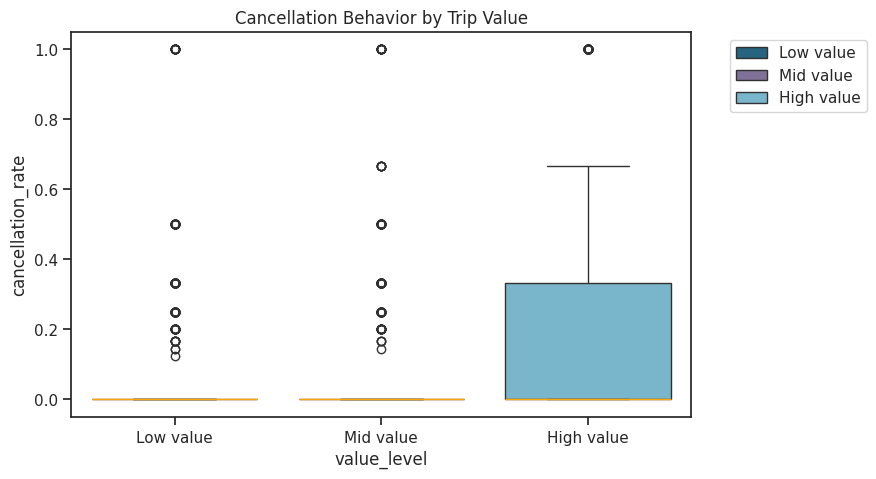

In [115]:
# Cancellation behavior by trip value
plt.figure(figsize=(8,5))
sns.boxplot(
    data=ul_df_analysis,
    x="value_level",
    y="cancellation_rate",
    hue = "value_level",
    palette = travel_palette[0:3],
    # set the median's color to orange to enfatize it
    medianprops=dict(color="orange", linewidth=1)
)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.title("Cancellation Behavior by Trip Value")
plt.show()

**Note**: This box plot compares cancellation behavior across users grouped by average trip value.

Across all value tiers, the median cancellation rate is close to zero, indicating that most users, regardless of spend, do not cancel the majority of their trips.

However, a key difference emerges in the distribution:

- **Low-value and mid-value users** show tightly concentrated cancellation behavior, with cancellations appearing mainly as rare outliers.
- **High-value users** exhibit much wider dispersion, with a longer upper tail and substantially higher variability in cancellation rates.

This indicates that while high-value users are not systematically more likely to cancel,
**when cancellations occur, they tend to be more extreme and less predictable**.

In other words, **high spend increases volatility rather than average cancellation propensity**.

This distinction is important: monetary value alone does not capture behavioral risk, and high-value users may require different engagement or reassurance strategies to reduce uncertainty around expensive trips.

#### 5.5 Value Synthesis: RFM and CLTV

##### 5.5.1  RFM Score Construction and Distribution

**RFM** (Recency - Frequency - Monetary)

**Recency**: how recently a user booked a trip.
Smaller “days since last booking” = more recent = more engaged.

**Frequency**: how often a user books.
More booking sessions = higher frequency.

**Monetary**: how much value the user generates in spend.
Higher total spend = higher monetary value.

**Why RFM is useful**: it summarizes when a user last booked, how often they book, and how much they spend: three core signals for segmentation.

###### RFM Score Construction

In [116]:
# RFM Score
# R = days since last booking (smaller is better)
# F = number of booking sessions (bigger is better)
# M = total spend (bigger is better)

rfm = ul_df_analysis.copy()
# Dates already converted to datetime in the data validation step
# last_booking_date and last_session_date are safe to use here

# Reference date: last observed activity in the dataset (+1 day to avoid 0)
ref_date = rfm["last_session_date"].max() + pd.Timedelta(days=1)

# Compute raw R, F, M
rfm["R_days"] = (ref_date - rfm["last_booking_date"]).dt.days
rfm["F"] = rfm["n_booking_sessions"].astype(int)
rfm["M"] = rfm["total_spend"].astype(float)

# Non-bookers: last_booking_date is NaT -> R_days NaN.
# Set them to "worst recency" = max R + 1 (so they score low on R)
worst_R = int(np.nanmax(rfm["R_days"])) + 1
rfm["R_days"] = rfm["R_days"].fillna(worst_R)

# RFM scoring (1..5)
# Recency: lower R_days => better score, so we invert by using qcut on negative R_days
# Frequency/Monetary: higher => better score
# duplicates='drop' avoids errors if many ties (common with small discrete F)

rfm["R_score"] = pd.qcut(-rfm["R_days"], q=5, labels=[1, 2, 3, 4, 5], duplicates="drop").astype(int)
# because qcut assigns the lowest value to the highest bin, we invert the values here with -rfm["R_days"]
# so R_days 5 ---> -R_days = -5
# R_days 200 ---> -Rdays = -200
# then qcut() assigns score 5 to the users more recent (-5) only five days and score 1 to the users less recent (-200) 200 days ago


# F can have many ties (0..8). If qcut collapses bins, fallback to cut on rank...so we can have two equals quantiles and the qcut collapses the bins
# then we force in this case the rank to be unique with rank(method="first")
try:
    rfm["F_score"] = pd.qcut(rfm["F"], q=5, labels=[1, 2, 3, 4, 5], duplicates="drop").astype(int)
except ValueError:
    rfm["F_score"] = pd.qcut(rfm["F"].rank(method="first"), q=5, labels=[1, 2, 3, 4, 5]).astype(int)

# M also can have ties/zeros; same safe approach
try:
    rfm["M_score"] = pd.qcut(rfm["M"], q=5, labels=[1, 2, 3, 4, 5], duplicates="drop").astype(int)
except ValueError:
    rfm["M_score"] = pd.qcut(rfm["M"].rank(method="first"), q=5, labels=[1, 2, 3, 4, 5]).astype(int)

# Combined score / segment key
rfm["RFM_score"] = rfm["R_score"] + rfm["F_score"] + rfm["M_score"]          # 3..15
rfm["RFM_segment"] = (
    rfm["R_score"].astype(str) + "-" + rfm["F_score"].astype(str) + "-" + rfm["M_score"].astype(str)
)

# quick overview
rfm[["R_days", "F", "M", "R_score", "F_score", "M_score", "RFM_score"]].describe()


,R_days,F,M,R_score,F_score,M_score,RFM_score
count,5998.000000,5998.000000,5998.000000,5998.000000,5998.000000,5998.000000,5998.000000
mean,107.635879,2.646382,3495.610747,2.983328,2.687396,3.000000,8.670724
std,108.666296,1.508963,3356.455568,1.406193,1.310981,1.414449,3.455539
min,8.000000,0.000000,0.000000,1.000000,1.000000,1.000000,3.000000
25%,36.000000,2.000000,1361.992500,2.000000,2.000000,2.000000,6.000000
50%,79.000000,3.000000,2718.255000,3.000000,3.000000,3.000000,9.000000
75%,133.000000,4.000000,4680.050000,4.000000,4.000000,4.000000,11.000000
max,440.000000,8.000000,43896.890000,5.000000,5.000000,5.000000,15.000000


In [117]:
rfm.head()

,user_id,gender,married,birthdate,has_children,home_country,home_city,home_airport,sign_up_date,first_session_date,...,experience_level,value_level,R_days,F,M,R_score,F_score,M_score,RFM_score,RFM_segment
0,23557,F,True,1958-12-08,False,usa,new york,LGA,2021-07-22,2023-01-04 19:30:00,...,Occasional,Mid value,15.0,2,3802.00,5,2,4,11,5-2-4
1,94883,F,True,1972-03-16,False,usa,kansas city,MCI,2022-02-07,2023-01-10 12:20:00,...,Occasional,Low value,109.0,2,1094.09,2,2,2,6,2-2-2
2,101486,F,True,1972-12-07,True,usa,tacoma,TCM,2022-02-17,2023-01-21 08:02:00,...,Occasional,Mid value,42.0,2,2641.91,4,2,3,9,4-2-3
3,101961,F,True,1980-09-14,False,usa,boston,BOS,2022-02-17,2023-01-19 03:38:00,...,Frequent,Low value,37.0,5,4040.66,4,5,4,13,4-5-4
4,106907,F,True,1978-11-17,True,usa,miami,TNT,2022-02-24,2023-01-10 17:24:00,...,One-timers,High value,53.0,1,36318.12,4,1,5,10,4-1-5


**Note**: The RFM results show that our users are well-spread across the three measures: recency, frequency, and money spent.  
Most users book sometimes and spend a normal amount, while a smaller group spends much more than the rest.  
Recency shows the biggest difference: some users booked very recently, while others have not booked for a long time.  
The RFM scores also look clean and stable, which means they reflect real user behavior and not random noise in the data.

###### Distribution of RFM Scores - Histogram

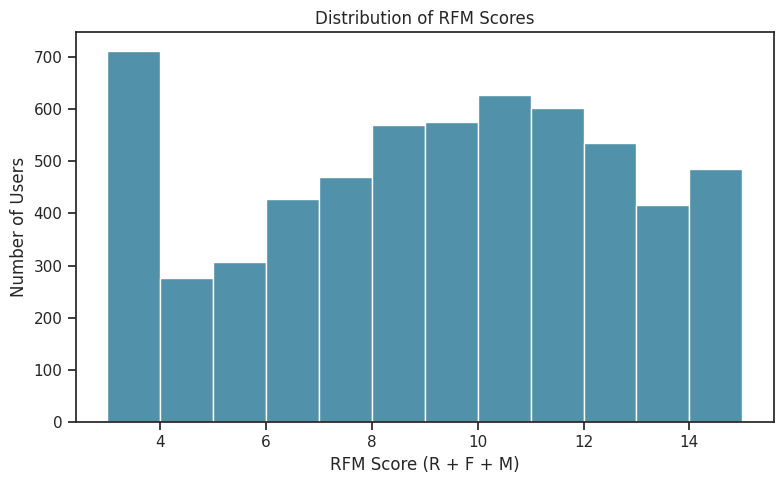

In [118]:
# Distribution of RFM scores - Histogram
plt.figure(figsize=(8,5))
sns.histplot(
    rfm["RFM_score"],
    bins=12,
    color=travel_palette[0]
)
plt.title("Distribution of RFM Scores")
plt.xlabel("RFM Score (R + F + M)")
plt.ylabel("Number of Users")
plt.tight_layout()
plt.show()


**Note**: The distribution of RFM scores shows a broad spread across the full score range, with a higher concentration in the mid-to-high values.

This indicates that the cohort includes a substantial share of users with moderate to strong engagement and booking activity, rather than being dominated by either extremely low or extremely high behavioral profiles.

Importantly, the RFM score reflects **behavioral intensity and booking intent**, not realized revenue.
Differences observed at higher RFM levels therefore motivate a deeper analysis combining RFM with **cancellation behavior and CLTV**, to distinguish users who are active from those who are consistently valuable.

###### RFM Score Distributions - Count Plots

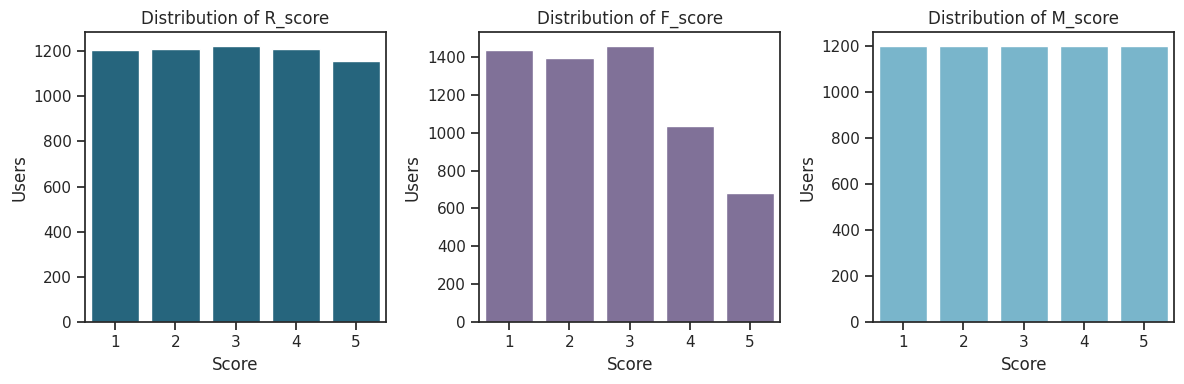

In [119]:
# RFM Score Distribution
plt.figure(figsize=(12,4))

for i, col in enumerate(["R_score", "F_score", "M_score"]):
    plt.subplot(1, 3, i+1)
    sns.countplot(
        x=col,
        data=rfm,
        color=travel_palette[i]
    )
    plt.title(f"Distribution of {col}")
    plt.xlabel("Score")
    plt.ylabel("Users")

plt.tight_layout()
plt.show()


**Note**: The three distributions reflect the quantile-based construction of RFM scores.

**Recency (R_score)** and **Monetary (M_score)** show a nearly uniform distribution across score levels when variables are discretized using quantiles. Both dimensions are well spread and do not suffer from concentration or dominance by a small subset of users.

**Frequency (F_score)** displays a more uneven distribution, with fewer users in the highest score. This is a structural effect of the data: booking frequency is a discrete and bounded variable, with many users sharing similar values and fewer users reaching very high booking counts.

Overall, these distributions indicate that:

- RFM scores are numerically **stable and interpretable**

- No single dimension dominates the combined RFM score

- Differences observed in later analyses are driven by **real behavioral variation**, not by artifacts of the scoring procedure

###### RFM Heatmap (Recency x Frequency --> Monetary)

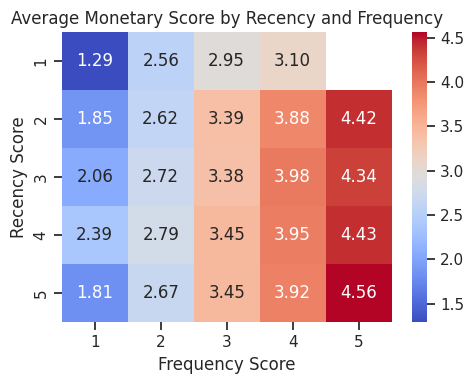

In [120]:
rfm_pivot = (
    rfm
    .groupby(["R_score", "F_score"])
    .agg(avg_M=("M_score", "mean"))
    .reset_index()
    .pivot(index="R_score", columns="F_score", values="avg_M")
)

plt.figure(figsize=(5,4))
sns.heatmap(
    rfm_pivot,
    annot=True,
    fmt=".2f",
    cmap="coolwarm"
)
plt.title("Average Monetary Score by Recency and Frequency")
plt.xlabel("Frequency Score")
plt.ylabel("Recency Score")
plt.tight_layout()
plt.show()

**Note**: This heatmap shows **how monetary value (M score)** varies jointly with **recency** and **frequency**.

A clear gradient emerges along the frequency axis: users with higher frequency scores consistently exhibit higher average monetary scores, regardless of recency. **Repeat booking behavior is the strongest driver of total monetary value**.

Recency plays a secondary but complementary role. Within the same frequency level, more recent users tend to have slightly higher monetary scores, suggesting that recent engagement reinforces value but does not replace sustained booking activity.

Importantly, there is no single “best” combination of recency and frequency. High monetary value appears across multiple cells, indicating that **different behavioral paths can lead to similar economic outcomes**.

This pattern supports treating r**ecency and frequency as independent but interacting dimensions**, and motivates combining them with monetary value (RFM) rather than relying on a single behavioral metric.

##### 5.5.2 RFM Personas

**RFM Personas**
RFM scores are useful numerically, but they are not immediately interpretable.
To make user behavior more readable and actionable, RFM combinations are mapped to behavioral personas that summarize how recent, frequent, and valuable a user is.

These personas do not represent strict business segments yet.
They provide an interpretive layer that helps translate numeric scores into intuitive user profiles.

- High R, F, M = strong, active, valuable user
- Low R = disengaged or inactive
- Low F = occasional user
- High M alone ≠ loyal user

###### assing_rfm_persona Function

In [121]:
# assign RFM persona function
def assign_rfm_persona(row):
    R = row["R_score"]
    F = row["F_score"]
    M = row["M_score"]

    # 1) CHAMPIONS: top on all dimensions
    if R >= 4 and F >= 4 and M >= 4:
        return "Champions"

    # 2) LOYAL: frequent + recent (value can vary)
    if R >= 3 and F >= 4:
        return "Loyal Customers"

    # 3) BIG SPENDERS: high monetary, still relatively recent
    if M >= 4 and R >= 3:
        return "Big Spenders"

    # 4) POTENTIAL LOYALISTS: very recent but not frequent yet
    if R >= 4 and F <= 3:
        return "Potential Loyalists"

    # 5) NEED ATTENTION: average recency + average frequency
    if R == 3 and F <=3:
        return "Need Attention"

    # 6) AT RISK: used to be active (freq), now less recent
    if R <= 2 and F >= 3:
        return "At Risk"

    # 7) CAN'T LOSE THEM: not recent + not frequent, but high value
    if R <= 2 and F <= 3 and M >= 3:
        return "Can't Lose Them"

    # 8) HIBERNATING: low across the board
    if R <= 2 and F <= 2 and M <= 2:
        return "Hibernating"

    return "Others"

###### Feature Enginering: `RFM_persona`

In [122]:
# assign RFM scores to a new column of rfm dataframe
rfm["RFM_persona"] = rfm.apply(assign_rfm_persona, axis=1)

###### User Distribution by RFM Persona - Count Plot

In [123]:
# count percentage
persona_counts = (
    rfm["RFM_persona"]
    .value_counts()
    .reset_index()
)

persona_counts.columns = ["RFM_persona", "count"]
persona_counts["pct"] = persona_counts["count"] / persona_counts["count"].sum() * 100


In [124]:
# persona palette
persona_palette = {
    "At Risk": "#C0392B",            # red fur risk
    "Hibernating": "#7F8C8D",        # grey fur hibernating
    "Champions": travel_palette[0],
    "Loyal Customers": travel_palette[3],
    "Potential Loyalists": travel_palette[2],
    "Big Spenders": travel_palette[5],
    "Need Attention": "#F39C12", # yellow
    "Can't Lose Them": travel_palette[1],
    "Others": "#BDC3C7" # light grey
}

###### User Distribution by RFM Persona - Count Plot

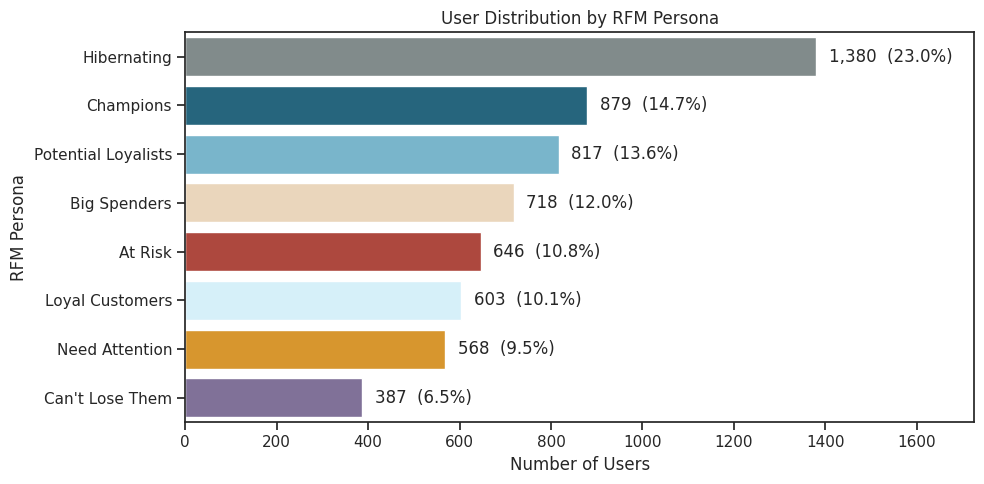

In [125]:
plt.figure(figsize=(10, 5))

ax = sns.barplot(
    data=persona_counts,
    y="RFM_persona",
    x="count",
    hue = "RFM_persona",
    order=persona_counts["RFM_persona"],
    palette=persona_palette
)

# Padding X axis
max_count = persona_counts["count"].max()
ax.set_xlim(0, max_count * 1.25)

# Annotation
for i, row in persona_counts.iterrows():
    ax.text(
        row["count"] + max_count * 0.02,
        i,
        f'{row["count"]:,}  ({row["pct"]:.1f}%)',
        va="center"
    )

plt.title("User Distribution by RFM Persona")
plt.xlabel("Number of Users")
plt.ylabel("RFM Persona")
plt.tight_layout()
plt.show()

**Note**: This chart illustrates how users are distributed across RFM personas.

A substantial portion of the cohort falls into **Hibernating**, which alone represents nearly a quarter of all users, followed by sizeable groups of **Potential Loyalists**, **Big Spenders**, and **At Risk** profiles. This concentration in lower-engagement or unstable segments suggests that a large share of the user base shows limited activity, inconsistent value, or early signs of disengagement.

Conversely, **Champions**, **Loyal Customers**, and **Can't Lose Them** form a smaller but strategically essential minority. These users demonstrate stronger behavioral signals, either through recency, frequency, or monetary value, and represent the core from which sustainable revenue and long-term retention are most likely to emerge.

The distribution underscores why segmentation is critical: user behavior is highly uneven, and treating the entire cohort uniformly would obscure both risk and opportunity. Targeted strategies must therefore differentiate between dormant users, fragile segments, and high-value clusters to maximize impact and resource efficiency.

##### 5.5.3 Customer Lifetime Value (CLTV - 3 Months)

CLTV is computed using a deterministic forward-looking approach.
The expected number of future bookings is estimated from the user's historical booking frequency normalized by observation time (bookings per day), and projected over a 3-month horizon.
This avoids relying on session counts alone and ensures comparability across users with different tenure lengths.

###### CLTV Construction

In [126]:
# CLTV (Customer Lifetime Value) calculation
cltv = ul_df_analysis.copy()

# Average spend per booked trip
cltv["avg_spend_per_trip"] = (
    cltv["total_spend"] / cltv["n_booking_sessions"]
).replace([np.inf, -np.inf], np.nan)

# Booking rate per day feature
cltv["booking_rate_per_day"] = (
    cltv["n_booking_sessions"] / cltv["tenure_days"]
)

# CLTV over next 3 months (= 90 days)
cltv["CLTV_3m"] = (
    cltv["booking_rate_per_day"] * 90 * cltv["avg_spend_per_trip"]
)

# Non-bookers CLTV = 0
cltv["CLTV_3m"] = cltv["CLTV_3m"].fillna(0)

# Merge CLTV with RFM
rfm = rfm.merge(
    cltv[["user_id", "CLTV_3m"]],
    on="user_id",
    how="left"
)

**Note**: CLTV is merged after RFM computation to preserve a clear separation between behavioral segmentation and economic valuation.  
This allows the same behavioral persona to be analyzed under different value perspectives.

##### 5.5.4 RFM vs CLTV Landscape

RFM captures behavioral intensity, while CLTV captures economic value.  
Using both separates active users from valuable ones.

###### User Value Landscape: RFM vs CLTV - Scatter Plot + Median Quadrants

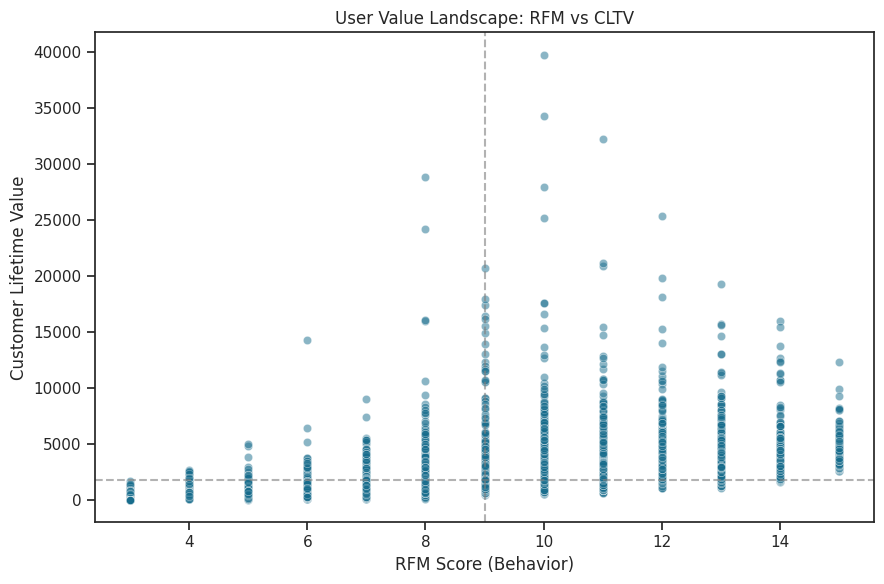

In [127]:
# Scatter plot + median quadrants
plt.figure(figsize=(9,6))

sns.scatterplot(
    data=rfm,
    x="RFM_score",
    y="CLTV_3m",
    alpha=0.5,
    color = travel_palette[0]
)

# Medians
plt.axvline(rfm["RFM_score"].median(), color="grey", linestyle="--", alpha=0.6)
plt.axhline(rfm["CLTV_3m"].median(), color="grey", linestyle="--", alpha=0.6)

plt.title("User Value Landscape: RFM vs CLTV")
plt.xlabel("RFM Score (Behavior)")
plt.ylabel("Customer Lifetime Value")
plt.tight_layout()
plt.show()


**Note**: This chart contrasts **behavioral engagement (RFM score)** with **economic value (3-month CLTV)**.

While higher RFM scores are generally associated with higher lifetime value, the relationship **is far from linear**. Users with similar RFM scores can generate **very different economic outcomes**.

Several key patterns emerge:

- Some users with **mid-level RFM scores** reach CLTV levels comparable to the most active users, showing that **value does not depend on engagement alone**.

- Conversely, some users with **high RFM scores** generate only moderate CLTV, suggesting frequent but relatively standardized or lower-value trips.

- The top-right quadrant highlights users who combine strong behavior and high value, while the bottom-right quadrant reveals **active but economically limited users**.

This separation confirms that:

- **RFM explains how users behave**

- **CLTV explains how much they are worth**

Using both dimensions together allows us to identify not only who is active, but **where engagement actually translates into economic impact**.

###### RFM Persona Summary

In [128]:
# RFM personas summary
rfm_summary = (
    rfm
    .groupby("RFM_persona", observed=True)
    .agg(
        users=("user_id", "count"),
        avg_CLTV=("CLTV_3m", "mean"),
        median_CLTV=("CLTV_3m", "median"),
        avg_RFM=("RFM_score", "mean")
    )
    .sort_values("avg_CLTV", ascending=False)
)

display(rfm_summary)


,users,avg_CLTV,median_CLTV,avg_RFM
RFM_persona,,,,
Big Spenders,718,4108.904388,3275.963193,10.926184
Champions,879,3661.761288,3226.409396,13.617747
Can't Lose Them,387,3627.184755,2554.362406,7.067183
At Risk,646,3068.928517,2335.826739,8.814241
Loyal Customers,603,2880.284626,2201.850000,11.447761
Need Attention,568,1361.845751,1306.189654,7.325704
Potential Loyalists,817,1182.386717,1141.803797,8.951040
Hibernating,1380,543.391617,437.410400,3.902899


**Note**: This table summarizes how behavioral personas (RFM) translate into economic value (CLTV) over the next 3 months.

Several important insights emerge:

- **Big Spenders** generate the highest average and median CLTV, despite not having the highest RFM scores. Monetary intensity per trip can outweigh pure engagement frequency.

- **Champions** remain a critical segment: they combine very strong behavioral signals with consistently high value, making them both reliable and profitable in the short term.

- **Can't Lose Them** represent a strategically critical persona: despite relatively weak RFM signals (especially recency), their average and median CLTV remain very high. This suggests historically valuable customers who are disengaging but still carry substantial short-term economic potential, making them prime candidates for reactivation efforts.

- **At Risk** users stand out as a fragile but economically relevant group: their CLTV is comparable to Loyal Customers, despite significantly lower recency and frequency.

- **Loyal Customers** show solid engagement (high RFM) but lower CLTV than Big Spenders and Champions, indicating more standardized or lower-value trips ather than high-spend behavior.

- **Potential Loyalists** and **Need Attention** display moderate behavioral activity but limited short-term value. These segments represent growth potential rather than immediate profitability and may benefit more from nurturing than from aggressive incentives.

- **Hibernating** users form the lowest-value segment across all dimensions, both behaviorally and economically, confirming their low priority in short-term value-driven strategies
,
Overall, this table reinforces a key takeaway:
**high engagement does not always imply high value, and high value does not always come from the most active users**.
This distinction motivates the need to combine behavioral segmentation with value-based and trip-level characteristics before defining targeting or incentive strategies.

##### 5.5.5 RFM Persona x Trip Anatomy

###### Trip Complexity by RFM Persona (Average Nights) - Box Plot

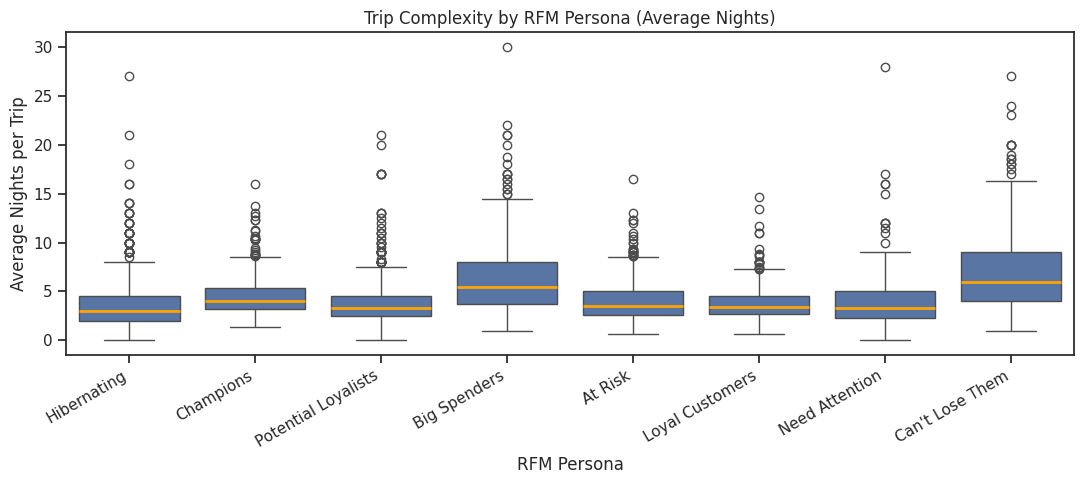

In [129]:
# RFM Persona x Trip Anatomy
plt.figure(figsize=(11, 5))

sns.boxplot(
    data=rfm,
    x="RFM_persona",
    y="avg_nights",
    order=(
        rfm["RFM_persona"]
        .value_counts()
        .index
    ),
    medianprops=dict(color="orange", linewidth=2)
)

plt.title("Trip Complexity by RFM Persona (Average Nights)")
plt.xlabel("RFM Persona")
plt.ylabel("Average Nights per Trip")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

**Note**: This box plot illustrates how average trip duration varies across RFM personas, revealing structural differences in travel behavior that extend beyond engagement or value scores alone.

Several patterns emerge clearly:

- **Big Spenders** show both the highest median trip duration and the broadest spread, indicating a mix of standard stays and a notable share of extended, more complex trips.

- **Can't Lose Them** also display elevated medians and long upper tails, suggesting that users with declining engagement but historically high value still tend to book longer, more substantial trips.

- In contrast, **Champions** and **Loyal Customers** cluster around moderate trip lengths, with relatively contained variability. Their engagement is strong, but their travel patterns appear more consistent and less extreme.

- **Hibernating**, **Need Attention**, and **Potential Loyalists** exhibit shorter, more compact trip durations, reflecting simpler travel behavior and lower commitment levels.

Overall, this chart highlights that **high engagement does not necessarily imply high trip complexity**.
Some of the longest and most complex trips are undertaken by users who are not the most behaviorally active, reinforcing the need to consider trip anatomy alongside RFM behavior.

##### 5.5.6 CLTV x Cancellation Risk

###### Customer Value vs Cancellation Risk

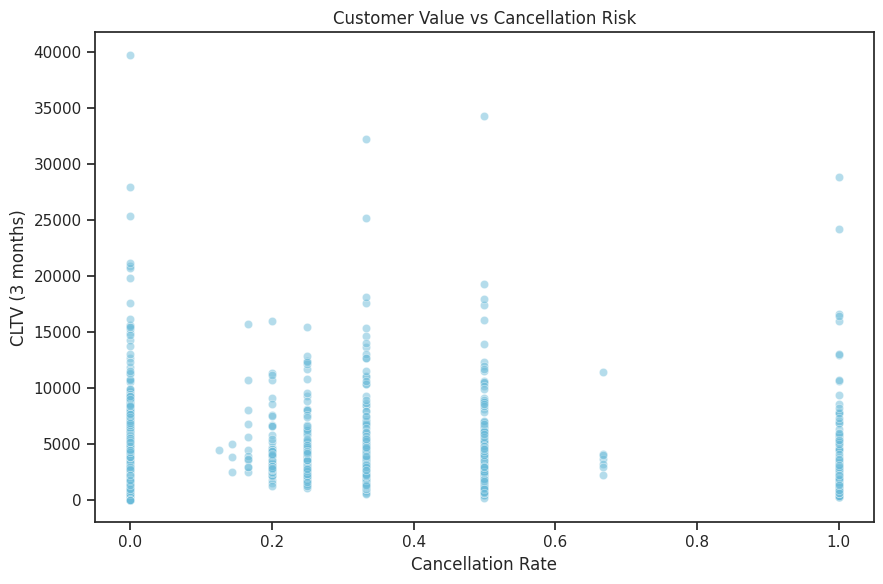

In [130]:
# Customer Value vs Cancellation Risk
plt.figure(figsize=(9, 6))

sns.scatterplot(
    data=rfm,
    x="cancellation_rate", # to try has_cancellation instead of cancellation_rate
    # interessante anche provare a mettere come hue rfm persona...
    y="CLTV_3m",
    color = travel_palette[2],
    alpha=0.5
)

plt.title("Customer Value vs Cancellation Risk")
plt.xlabel("Cancellation Rate")
plt.ylabel("CLTV (3 months)")
plt.tight_layout()
plt.show()


**Note**: This chart shows that **high economic value is not exclusive to low-risk users**.

While many high-CLTV users exhibit low or zero cancellation rates, a non-negligible share of valuable users appears across medium and high cancellation levels.
Some of the highest future values are observed among users with **moderate to high cancellation risk**.

This indicates that:

- Cancellation risk does not imply low value
- Risk and value are orthogonal dimensions, not opposites

**High uncertainty does not necessarily signal low potential, instead, it often accompanies complex or high-stakes trips**.


##### 5.5.7 Trip Complexity vs Customer Lifetime Value

###### Trip Complexity vs Customer Lifetime Value - Scatter Plot

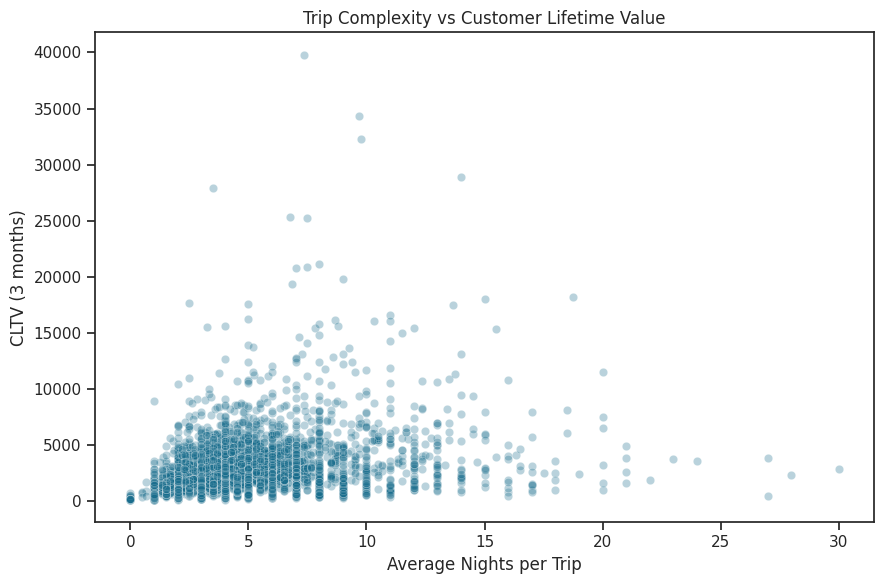

In [131]:
# Trip complexity vs CLTV - Scatter Plot
plt.figure(figsize=(9, 6))

sns.scatterplot(
    data=rfm,
    x="avg_nights",
    y="CLTV_3m",
    color = travel_palette[0],
    alpha=0.3
)

plt.title("Trip Complexity vs Customer Lifetime Value")
plt.xlabel("Average Nights per Trip")
plt.ylabel("CLTV (3 months)")
plt.tight_layout()
plt.show()

**Note**: Trip complexity and customer lifetime value show a clear but non-linear relationship.

Users with **longer and more complex trips** tend to populate the upper range of future value, although with significantly higher dispersion.
Short and standardized trips are associated with lower and more concentrated CLTV outcomes.

This pattern suggests that:

- Complexity often correlates with higher future value
- But also introduces higher variability and uncertainty

Complex trips are not inherently risky or inefficient, they are **high-potential but fragile**.

#### 5.6 Segmentation and Clustering Ready User Datasets

###### Update the Dataset with RFM and CLTV

In [132]:
# save RFM in ul_df_analysis dataframe with left join
ul_df_analysis = ul_df_analysis.merge(
    rfm[["user_id", "R_days", "R_score", "F_score", "M_score", "RFM_score", "RFM_segment", "RFM_persona", "CLTV_3m"]],
    on="user_id",
    how="left"
)

In [133]:
# Presence flags (semantic signals)
# ------------------------------------------------------------
ul_df_analysis["has_flight_history"] = ul_df_analysis["avg_trip_duration_days"].notna()
ul_df_analysis["has_hotel_history"]  = ul_df_analysis["avg_nights"].notna()


In [134]:
# EDA only columns
eda_only_cols = [ "nights_bucket", "cancellation_bucket", "booking_level", "cancellation_level", "booking_profile", "experience_level", "value_level" ]

In [135]:
# Remove EDA only columns
ul_df_temp = ul_df_analysis.copy()
ul_df_temp = ul_df_temp.drop(eda_only_cols, axis=1)
# Quick check
ul_df_temp.head()

,user_id,gender,married,birthdate,has_children,home_country,home_city,home_airport,sign_up_date,first_session_date,...,R_days,R_score,F_score,M_score,RFM_score,RFM_segment,RFM_persona,CLTV_3m,has_flight_history,has_hotel_history
0,23557,F,True,1958-12-08,False,usa,new york,LGA,2021-07-22,2023-01-04 19:30:00,...,15.0,5,2,4,11,5-2-4,Big Spenders,1800.947368,False,True
1,94883,F,True,1972-03-16,False,usa,kansas city,MCI,2022-02-07,2023-01-10 12:20:00,...,109.0,2,2,2,6,2-2-2,Hibernating,713.536957,True,True
2,101486,F,True,1972-12-07,True,usa,tacoma,TCM,2022-02-17,2023-01-21 08:02:00,...,42.0,4,2,3,9,4-2-3,Potential Loyalists,1335.797191,True,True
3,101961,F,True,1980-09-14,False,usa,boston,BOS,2022-02-17,2023-01-19 03:38:00,...,37.0,4,5,4,13,4-5-4,Champions,2361.424675,True,True
4,106907,F,True,1978-11-17,True,usa,miami,TNT,2022-02-24,2023-01-10 17:24:00,...,53.0,4,1,5,10,4-1-5,Big Spenders,16592.034518,True,True


###### Save the Dataset for the Segmentation

In [136]:
# Save the final user_level segmentation dataset (overwrite allowed)
output_path = "data/intermediate/user_level_for_segmentation.csv"
ul_df_temp.to_csv(output_path, index=False)
print(f"User-level segmentation dataset saved successfully to: {output_path}")

User-level segmentation dataset saved successfully to: data/intermediate/user_level_for_segmentation.csv


###### Clustering-Oriented Feature Preparation

The following transformations are applied **only** for clustering purposes.  
They are not used in rule-based segmentation.

In [137]:
cluster_df = ul_df_temp.copy()

# Semantic imputation: absence of product usage -> 0
cols_to_zero = [
    "avg_distance_km",
    "avg_seats",
    "avg_checked_bags",
    "avg_trip_duration_days",
    "avg_nights",
    "avg_rooms",
    "avg_spend_per_trip"
]

cluster_df[cols_to_zero] = cluster_df[cols_to_zero].fillna(0)
# Keep explicit presence flags
# has_flight_history, has_hotel_history already exist

###### Save the Dataset for Clustering

In [138]:
# Save the final user_level clustering dataset (overwrite allowed)
output_path = "data/intermediate/user_level_for_clustering.csv"
cluster_df.to_csv(output_path, index=False)
print(f"User-level clustering dataset saved successfully to: {output_path}")

User-level clustering dataset saved successfully to: data/intermediate/user_level_for_clustering.csv


**Note**:  
This step consolidates all engineered features, behavioral signals, and value metrics into a finalized **user-level analytical table**.

The merge is intentionally performed **at the very end of the exploratory workflow** to preserve a clear separation between:

- Feature understanding and validation (EDA),

- Behavioral synthesis (RFM personas),

- Economic valuation (CLTV).

This user-level table represents the **single source of truth at the user level**.
From this table, **two purpose-specific analytical views are derived**:

- A segmentation-ready view, which preserves semantic missingness for interpretability and business logic

- A clustering-ready view, which applies controlled, semantic imputations to enable numerical modeling

Both views are generated from the same user-level table and will be consumed in **Notebook 05** for:

- Rule-based (business-driven) segmentation

- Machine learning clustering techniques.

This approach ensures **conceptual consistency**, **analytical transparency**, and **methodological flexibility** across segmentation strategies.

**Decision-oriented summary**

At the user level, behavior separates along four independent dimensions:

- **Engagement** - how often users interact and book (summarized by RFM),
- **Economic value** - how much they spend (captured by total spend and CLTV),
- **Commitment risk** - how reliably bookings are completed (captured by cancellation behavior),
- **Trip complexity** - how complex bookings are in terms of itinerary structure, duration, and components.

These dimensions do not collapse into a single metric. Highly engaged users are not always the most valuable, and high-value users often exhibit higher uncertainty and risk due to increased trip complexity.

As a result, segmentation cannot rely on booking frequency or value alone. Both interpretable, rule-based logic and data-driven clustering are required to capture meaningful and actionable user profiles.

At this point, the user-level data has been fully explored, enriched, and validated.  
The analysis now moves from understanding user behavior to structuring it into actionable segments, explicitly balancing **behavioral patterns**, **economic value**, and **commitment risk**.
